In [1]:
#!!! temp - erase

import pandas as pd
from varseek.utils import add_vcrs_variant_type
unique_mcrs_df = pd.read_csv('/home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/unique_mcrs_df.csv')

if "DP_varseek" in unique_mcrs_df.columns:
    unique_mcrs_df.rename(columns={"DP_varseek": "AD_ALT_varseek"}, inplace=True)

if "vcrs_variant_type" not in unique_mcrs_df.columns:
    unique_mcrs_df = add_vcrs_variant_type(unique_mcrs_df, var_column="vcrs_header")

unique_mcrs_df.to_parquet('/home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/unique_mcrs_df.parquet')
!cp '/home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/unique_mcrs_df.parquet' '/data/Fig2/unique_mcrs_df.parquet'

# Synthetic data aggregate notebook

## How did we make this file? Run the commands below:
```bash
### Prep:
gget ref -w dna,gtf,cds,cdna -r 93 --out_dir data/reference/ensembl_grch37_release93 -d human_grch37
gunzip data/reference/ensembl_grch37_release93/Homo_sapiens.GRCh37.dna.primary_assembly.fa.gz
gunzip data/reference/ensembl_grch37_release93/Homo_sapiens.GRCh37.87.gtf.gz
gunzip data/reference/ensembl_grch37_release93/Homo_sapiens.GRCh37.cds.all.fa.gz
gunzip data/reference/ensembl_grch37_release93/Homo_sapiens.GRCh37.cdna.all.fa.gz
wget -O data/reference/ensembl_grch37_release93/1000GENOMES-phase_3.vcf.gz
STAR --runMode genomeGenerate --genomeDir data/reference/ensembl_grch37_release93/star_reference --genomeFastaFiles data/reference/ensembl_grch37_release93/Homo_sapiens.GRCh37.dna.primary_assembly.fa --sjdbGTFfile data/reference/ensembl_grch37_release93/Homo_sapiens.GRCh37.87.gtf --sjdbOverhang 149
gget cosmic -d -cv 101 -gv 37 -o data/reference -mc cancer None
python -c "varseek.utils.convert_mutation_cds_locations_to_cdna(input_csv_path=data/reference/CancerMutationCensus_AllData_Tsv_v101_GRCh37/CancerMutationCensus_AllData_v101_GRCh37_mutation_workflow.csv, output_csv_path=data/reference/CancerMutationCensus_AllData_Tsv_v101_GRCh37/CancerMutationCensus_AllData_v101_GRCh37_mutation_workflow.csv, cds_fasta_path=data/reference/ensembl_grch37_release93/Homo_sapiens.GRCh37.cds.all.fa, cdna_fasta_path=data/reference/ensembl_grch37_release93/Homo_sapiens.GRCh37.cdna.all.fa, strip_leading_Ns_cds=True)"
```
### Data generation
```bash
jupyter nbconvert --to notebook --execute --output Fig2_variant_simulation_output.ipynb notebooks/Fig2_variant_simulation.ipynb

python scripts/run_gatk_haplotypecaller_for_benchmarking.py \
--synthetic_read_fastq data/simulated_data_output/synthetic_reads.fq \
--unique_mcrs_df_path data/simulated_data_output/unique_mcrs_df.csv \
--out data/variant_simulation_alternative_tools \
--reference_genome_fasta data/reference/ensembl_grch37_release93/Homo_sapiens.GRCh37.dna.primary_assembly.fa \
--reference_genome_gtf data/reference/ensembl_grch37_release93/Homo_sapiens.GRCh37.87.gtf \
--genomes1000_vcf data/reference/ensembl_grch37_release93/1000GENOMES-phase_3.vcf \
--star_genome_dir data/reference/ensembl_grch37_release93/star_reference \
--cosmic_vcf data/simulated_data_output/synthetic_cosmic_simulated_reads.vcf.gz \
--java /home/jmrich/opt/jdk-17.0.12+7/bin/java \
--picard_jar /home/jmrich/opt/picard.jar \
--disable_tool_default_read_filters \
--threads 4

python scripts/run_gatk_mutect2_for_benchmarking.py \
--synthetic_read_fastq data/simulated_data_output/synthetic_reads.fq \
--unique_mcrs_df_path data/simulated_data_output/unique_mcrs_df.csv \
--out data/variant_simulation_alternative_tools \
--reference_genome_fasta data/reference/ensembl_grch37_release93/Homo_sapiens.GRCh37.dna.primary_assembly.fa \
--reference_genome_gtf data/reference/ensembl_grch37_release93/Homo_sapiens.GRCh37.87.gtf \
--genomes1000_vcf data/reference/ensembl_grch37_release93/1000GENOMES-phase_3.vcf \
--star_genome_dir data/reference/ensembl_grch37_release93/star_reference \
--cosmic_vcf data/simulated_data_output/synthetic_cosmic_simulated_reads.vcf.gz \
--java /home/jmrich/opt/jdk-17.0.12+7/bin/java \
--picard_jar /home/jmrich/opt/picard.jar \
--disable_tool_default_read_filters \
--threads 4

python scripts/run_strelka_for_benchmarking.py \
--synthetic_read_fastq data/simulated_data_output/synthetic_reads.fq \
--unique_mcrs_df_path data/simulated_data_output/unique_mcrs_df.csv \
--out data/variant_simulation_alternative_tools \
--reference_genome_fasta data/reference/ensembl_grch37_release93/Homo_sapiens.GRCh37.dna.primary_assembly.fa \
--reference_genome_gtf data/reference/ensembl_grch37_release93/Homo_sapiens.GRCh37.87.gtf \
--star_genome_dir data/reference/ensembl_grch37_release93/star_reference \
--cosmic_vcf data/simulated_data_output/synthetic_cosmic_simulated_reads.vcf.gz \
--STRELKA_INSTALL_PATH /home/jmrich/opt/strelka-2.9.10.centos6_x86_64 \
--python2_env python2_env \
--threads 4


python scripts/run_varscan_for_benchmarking.py \
--synthetic_read_fastq data/simulated_data_output/synthetic_reads.fq \
--unique_mcrs_df_path data/simulated_data_output/unique_mcrs_df.csv \
--out data/variant_simulation_alternative_tools \
--reference_genome_fasta data/reference/ensembl_grch37_release93/Homo_sapiens.GRCh37.dna.primary_assembly.fa \
--reference_genome_gtf data/reference/ensembl_grch37_release93/Homo_sapiens.GRCh37.87.gtf \
--star_genome_dir data/reference/ensembl_grch37_release93/star_reference \
--cosmic_vcf data/simulated_data_output/synthetic_cosmic_simulated_reads.vcf.gz \
--VARSCAN_INSTALL_PATH /home/jmrich/opt/VarScan.v2.3.9.jar \
--threads 4


python scripts/run_deepvariant_for_benchmarking.py \
--synthetic_read_fastq data/simulated_data_output/synthetic_reads.fq \
--unique_mcrs_df_path data/simulated_data_output/unique_mcrs_df.csv \
--out data/variant_simulation_alternative_tools \
--reference_genome_fasta data/reference/ensembl_grch37_release93/Homo_sapiens.GRCh37.dna.primary_assembly.fa \
--reference_genome_gtf data/reference/ensembl_grch37_release93/Homo_sapiens.GRCh37.87.gtf \
--star_genome_dir data/reference/ensembl_grch37_release93/star_reference \
--cosmic_vcf data/simulated_data_output/synthetic_cosmic_simulated_reads.vcf.gz \
--model_dir data/benchmarking_tmp/deepvariant_model \
--read_length 150 \
--threads 4
```

In [1]:
try:
    import varseek as vk
except ImportError:
    print("varseek not found, installing...")
    !pip install -U -q varseek
# try:
#     import RLSRWP_2025
# except ImportError:
#     print("RLSRWP_2025 not found, installing...")
#     !pip install -q git+https://github.com/pachterlab/RLSRWP_2025.git

In [2]:
import os
import subprocess
import pandas as pd
import re
from scipy.optimize import curve_fit
from scipy.stats import linregress
from tqdm import tqdm
import numpy as np
import varseek as vk
from collections import OrderedDict
from upsetplot import UpSet, from_contents
import matplotlib.pyplot as plt

from RLSRWP_2025 import create_stratified_metric_bar_plot_updated, plot_overall_metrics, create_stratified_metric_line_plot, create_benchmarking_legend, plot_frequency_histogram, plot_time_and_memory_benchmarking, print_json, plot_precision_stratified_by_ad_alt, plot_recall_stratified_by_depth, plot_recall_stratified_by_tumor_purity
from varseek.utils import calculate_metrics, draw_confusion_matrix, find_specific_value_from_metric_text_file, color_map_20, add_vcrs_variant_type

varseek_directory = os.path.dirname(os.path.abspath(""))

Make sure to change any arguments in 2_variant_simulation.ipynb and any notebooks/scripts for tools I am benchmarking

In [3]:
tools = ["varseek", "gatk_mutect2", "gatk_haplotypecaller", "strelka2", "varscan", "deepvariant"]  # Ensure that any additional tools have columns mutation_detected_{tool} (bool) in unique_mcrs_df_path for each tool TOOL
fig2_output_dir = os.path.join(varseek_directory, "data", "Fig2")

unique_mcrs_df_path = os.path.join(fig2_output_dir, 'unique_mcrs_df.parquet')
variant_calling_stats_file = os.path.join(fig2_output_dir, "time_and_memory_benchmarking_report.txt")
STAR_stats_file = os.path.join(fig2_output_dir, "STAR_time_and_memory.txt")
hap_py_folder = os.path.join(varseek_directory, "data" "variant_simulation_alternative_tools", "hap_py_out")  #!!! hap_py_folder = "/home/jmrich/Desktop/RLSRWP_2025/data/variant_simulation_alternative_tools_BEST_June2025_including_counts_1_and_2/hap_py_out"  #!!! erase

This synthetic dataset has 30,174,400 reads and 381,837 variants

In [ ]:
unique_mcrs_df_url = "https://caltech.box.com/shared/static/8r5hm12muvphr9msui6u5uiip2bq16nm.parquet"
time_and_memory_benchmarking_stat_url = "https://caltech.box.com/shared/static/sb9zr167i86ddf4e5h0rpi2wy2ptyula.txt"
STAR_time_and_memory_benchmarking_stat_url = "https://caltech.box.com/shared/static/992hmlis9jc6pz6s6u1xneiel0lzvbnn.txt"
happy_url = "https://caltech.box.com/shared/static/ganiusile1is2kazgvjg02w7n533ifu4.gz"

os.makedirs(fig2_output_dir, exist_ok=True)

if not os.path.isfile(unique_mcrs_df_path):
    subprocess.run(["wget", unique_mcrs_df_url, "-O", unique_mcrs_df_path])

if not os.path.isfile(variant_calling_stats_file):
    subprocess.run(["wget", time_and_memory_benchmarking_stat_url, "-O", variant_calling_stats_file])

if not os.path.isfile(STAR_stats_file):
    subprocess.run(["wget", STAR_time_and_memory_benchmarking_stat_url, "-O", STAR_stats_file])

if not os.path.exists(hap_py_folder):
    hap_py_tarball = os.path.join(fig2_output_dir, "hap_py_out.tar")
    hap_py_folder = os.path.join(fig2_output_dir, "hap_py_out")
    subprocess.run(["wget", happy_url, "-O", hap_py_tarball])
    subprocess.run(["tar", "-xzf", hap_py_tarball, "-C", fig2_output_dir])

# Generate plots for Fig 2

In [4]:
if unique_mcrs_df_path.endswith(".csv"):
    unique_mcrs_df = pd.read_csv(unique_mcrs_df_path)
elif unique_mcrs_df_path.endswith(".parquet"):
    unique_mcrs_df = pd.read_parquet(unique_mcrs_df_path)
else:
    raise ValueError("unique_mcrs_df_path must be a .csv or .parquet file")

In [ ]:
if 'included_in_synthetic_reads_mutant' not in unique_mcrs_df.columns:
    unique_mcrs_df['included_in_synthetic_reads_mutant'] = unique_mcrs_df['number_of_reads_mutant'] > 0

fp_including_noncosmic_dict = {}
for tool in tools:
    assert f'mutation_detected_{tool}' in unique_mcrs_df.columns, f"mutation_detected_{tool} must be in unique_mcrs_df.columns"
    if f'TP_{tool}' not in unique_mcrs_df.columns:
        unique_mcrs_df[f'TP_{tool}'] = (unique_mcrs_df['included_in_synthetic_reads_mutant'] & unique_mcrs_df[f'mutation_detected_{tool}'])
    if f'TN_{tool}' not in unique_mcrs_df.columns:
        unique_mcrs_df[f'TN_{tool}'] = (~unique_mcrs_df['included_in_synthetic_reads_mutant'] & ~unique_mcrs_df[f'mutation_detected_{tool}'])
    if f'FP_{tool}' not in unique_mcrs_df.columns:
        unique_mcrs_df[f'FP_{tool}'] = (~unique_mcrs_df['included_in_synthetic_reads_mutant'] & unique_mcrs_df[f'mutation_detected_{tool}'])
    if f'FN_{tool}' not in unique_mcrs_df.columns:
        unique_mcrs_df[f'FN_{tool}'] = (unique_mcrs_df['included_in_synthetic_reads_mutant'] & ~unique_mcrs_df[f'mutation_detected_{tool}'])
    if f'mutation_expression_prediction_error_{tool}' not in unique_mcrs_df.columns and f'AD_ALT_{tool}' in unique_mcrs_df.columns:
        unique_mcrs_df[f'mutation_expression_prediction_error_{tool}'] = unique_mcrs_df[f'AD_ALT_{tool}'] - unique_mcrs_df['number_of_reads_mutant']

    assert unique_mcrs_df.loc[unique_mcrs_df[f'TP_{tool}'], f'mutation_detected_{tool}'].all(), (f"Some rows where TP_{tool}=True do not have mutation_detected_{tool}=True")
    assert unique_mcrs_df.loc[unique_mcrs_df[f'FP_{tool}'], f'mutation_detected_{tool}'].all(), (f"Some rows where FP_{tool}=True do not have mutation_detected_{tool}=True")
    assert (~unique_mcrs_df.loc[unique_mcrs_df[f'TN_{tool}'], f'mutation_detected_{tool}']).all(), (f"Some rows where TN_{tool}=True do not have mutation_detected_{tool}=False")
    assert (~unique_mcrs_df.loc[unique_mcrs_df[f'FN_{tool}'], f'mutation_detected_{tool}']).all(), (f"Some rows where FN_{tool}=True do not have mutation_detected_{tool}=False")

    reference_metrics_out = os.path.join(fig2_output_dir, f"reference_metrics_{tool}.txt")
    if not os.path.exists(reference_metrics_out):
        calculate_metrics(unique_mcrs_df, header_name = "vcrs_header", check_assertions = False, out = reference_metrics_out, suffix = f"_{tool}")
    fp_including_noncosmic_dict[tool] = find_specific_value_from_metric_text_file(reference_metrics_out, line = "FP including non-cosmic:")

### Add my own precision to include non-cosmic

In [ ]:
precision_stats_dict = {}
if os.path.exists(hap_py_folder):
    for tool in tools:
        if tool == "varseek":
            if "vcrs_variant_type" not in unique_mcrs_df.columns:
                unique_mcrs_df = add_vcrs_variant_type(unique_mcrs_df, var_column="vcrs_header")
            
            sub_df = unique_mcrs_df.loc[unique_mcrs_df["vcrs_variant_type"] == "substitution"]
            indel_df = unique_mcrs_df.loc[unique_mcrs_df["vcrs_variant_type"] != "substitution"]

            indel_tp = indel_df["TP_varseek"].sum()
            snp_tp = sub_df["TP_varseek"].sum()
            indel_fp = indel_df["FP_varseek"].sum()
            snp_fp = sub_df["FP_varseek"].sum()
        else:
            file_path = os.path.join(hap_py_folder, tool, "happy.summary.csv")
            df = pd.read_csv(file_path)

            # Select rows
            indel_all = df[(df["Type"] == "INDEL") & (df["Filter"] == "ALL")]
            snp_all = df[(df["Type"] == "SNP") & (df["Filter"] == "ALL")]

            # Extract values
            indel_tp = indel_all["TRUTH.TP"].values[0]
            snp_tp = snp_all["TRUTH.TP"].values[0]
            indel_fp = indel_all["QUERY.FP"].values[0]
            snp_fp = snp_all["QUERY.FP"].values[0]

        total_tp = indel_tp + snp_tp
        total_fp = indel_fp + snp_fp

        indel_precision = indel_tp / (indel_tp + indel_fp) if (indel_tp + indel_fp) > 0 else 0
        snp_precision = snp_tp / (snp_tp + snp_fp) if (snp_tp + snp_fp) > 0 else 0
        precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0

        # Store in nested dict
        precision_stats_dict[tool] = {
            "tp_indel": indel_tp,
            "tp_sub": snp_tp,
            "fp_indel": indel_fp,
            "fp_sub": snp_fp,
            "total_tp": total_tp,
            "total_fp": total_fp,
            "indel_precision": indel_precision,
            "snp_precision": snp_precision,
            "precision": precision
        }

    # for tool in tools:
    #     metric_dict_collection[tool]['precision'] = precision_stats_dict[tool]['precision']

varseek
TP: 380847, FP: 116405, FN: 990, TN: 4831249
Accuracy: 0.9779725681120393, Sensitivity: 0.9974072706416612, Specificity: 0.9764726878637835
Mean Expression Error: -0.7157236169990266, Median Expression Error: 0.0, Mean Magnitude Expression Error: 1.237370588755802, Median Magnitude Expression Error: 1.0


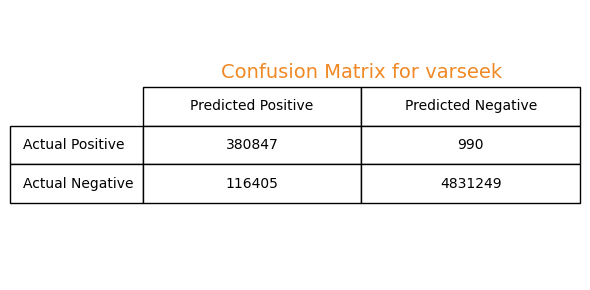

-------------------------------------------------------------------------------------------------------------------------------------------------------
gatk_mutect2
TP: 201955, FP: 549, FN: 179882, TN: 4947105
Accuracy: 0.966144796942147, Sensitivity: 0.5289036945083897, Specificity: 0.9998890383199796
Mean Expression Error: 111.72187710537789, Median Expression Error: 60.0, Mean Magnitude Expression Error: 124.78049082550628, Median Magnitude Expression Error: 69.0


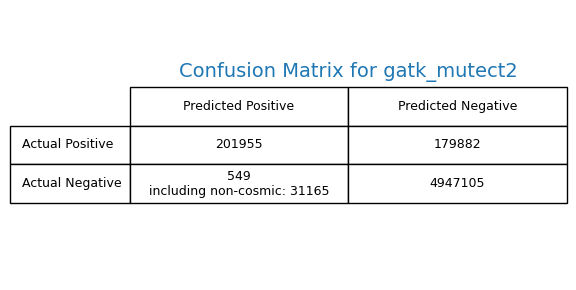

-------------------------------------------------------------------------------------------------------------------------------------------------------
gatk_haplotypecaller
TP: 126979, FP: 2745, FN: 254858, TN: 4944909
Accuracy: 0.9516646148759798, Sensitivity: 0.3325476577702004, Specificity: 0.9994451915998976
Mean Expression Error: 70.72071160412193, Median Expression Error: 29.0, Mean Magnitude Expression Error: 90.53267569947626, Median Magnitude Expression Error: 42.0


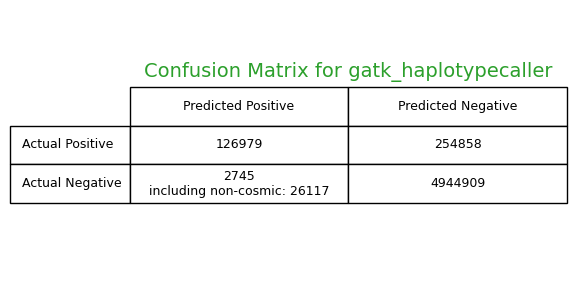

-------------------------------------------------------------------------------------------------------------------------------------------------------
strelka2
TP: 249774, FP: 20694, FN: 132063, TN: 4926960
Accuracy: 0.9713374128974043, Sensitivity: 0.6541377603532398, Specificity: 0.9958174116460043
Mean Expression Error: 135.30490478764943, Median Expression Error: 97.0, Mean Magnitude Expression Error: 135.49791253679342, Median Magnitude Expression Error: 97.0


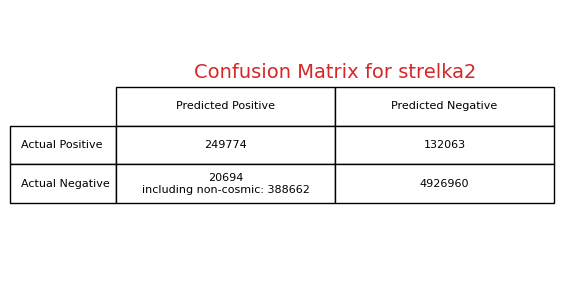

-------------------------------------------------------------------------------------------------------------------------------------------------------
varscan
TP: 177998, FP: 4661, FN: 203839, TN: 4942993
Accuracy: 0.960878065091019, Sensitivity: 0.4661622629551353, Specificity: 0.9990579373577861
Mean Expression Error: 217.4906165484478, Median Expression Error: 148.0, Mean Magnitude Expression Error: 217.6454037270488, Median Magnitude Expression Error: 148.0


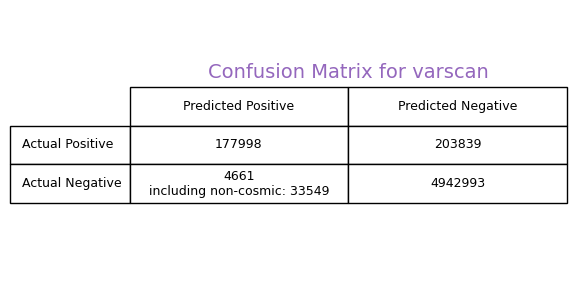

-------------------------------------------------------------------------------------------------------------------------------------------------------
deepvariant
TP: 132003, FP: 2709, FN: 249834, TN: 4944945
Accuracy: 0.9526140488838427, Sensitivity: 0.34570510453413367, Specificity: 0.9994524677756367
Mean Expression Error: 112.61130040172593, Median Expression Error: 56.0, Mean Magnitude Expression Error: 113.42797946734117, Median Magnitude Expression Error: 57.0


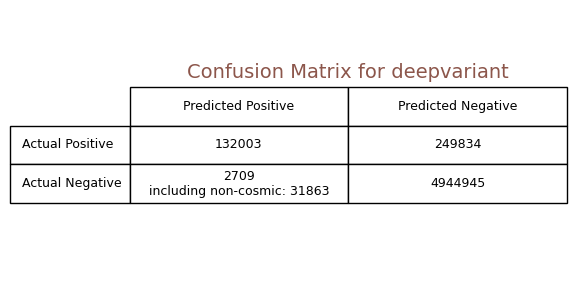

-------------------------------------------------------------------------------------------------------------------------------------------------------


In [9]:
update_precision_and_f1 = True

metric_dict_collection = OrderedDict()
for index, tool in enumerate(tools):
    print(tool)
    metric_dict_collection[tool] = calculate_metrics(unique_mcrs_df, header_name = "vcrs_header", suffix=f"_{tool}")  # out = f"{fig2_output_dir}/reference_metrics_{tool}.txt"
    if tool != "varseek":
        if fp_including_noncosmic_dict.get(tool, None) is not None:
            metric_dict_collection[tool]["FP including non-cosmic"] = fp_including_noncosmic_dict[tool]
        elif precision_stats_dict.get(tool, {}).get('total_fp', None) is not None:
            metric_dict_collection[tool]["FP including non-cosmic"] = precision_stats_dict[tool]['total_fp']
            if update_precision_and_f1:
                metric_dict_collection[tool]['precision'] = precision_stats_dict[tool]['precision']  #* optional

                precision = metric_dict_collection[tool]['precision']
                recall = metric_dict_collection[tool]['recall']
                metric_dict_collection[tool]['f1_score'] = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
    draw_confusion_matrix(metric_dict_collection[tool], title = f"Confusion Matrix for {tool}", title_color = color_map_20[index], additional_fp_key = "FP including non-cosmic", output_file=f"{fig2_output_dir}/confusion_matrix_{tool}.pdf")
    print("-------------------------------------------------------------------------------------------------------------------------------------------------------")

# Create legend

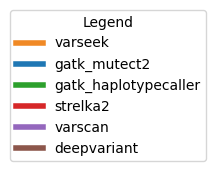

In [6]:
create_benchmarking_legend(tools, f"{fig2_output_dir}/legend.pdf")

# Bar plot of various metrics

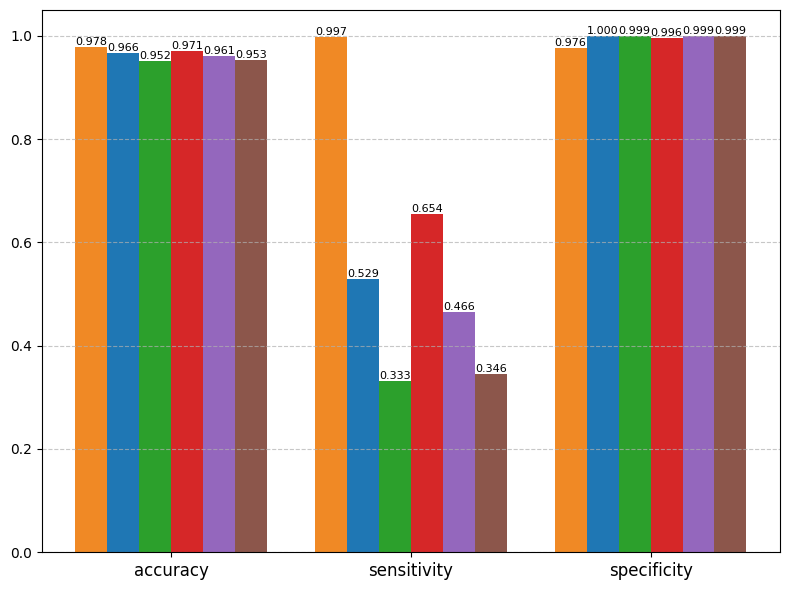

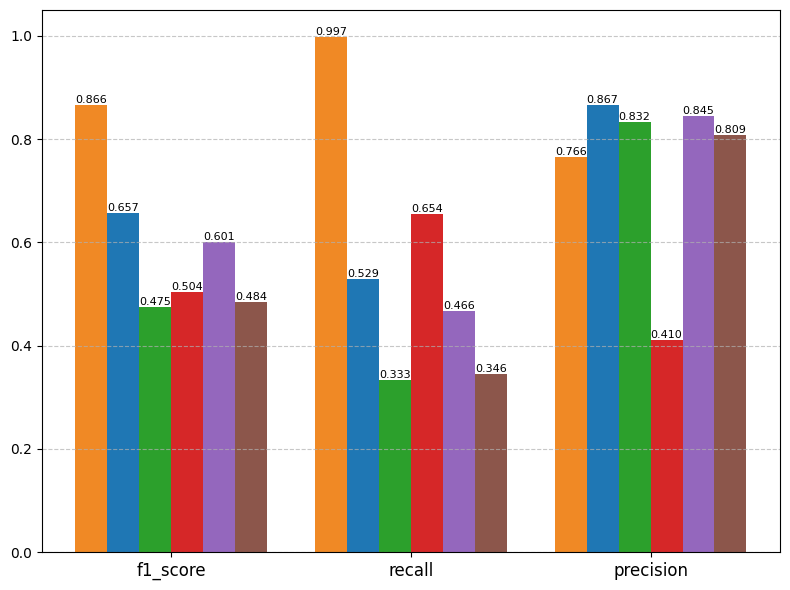

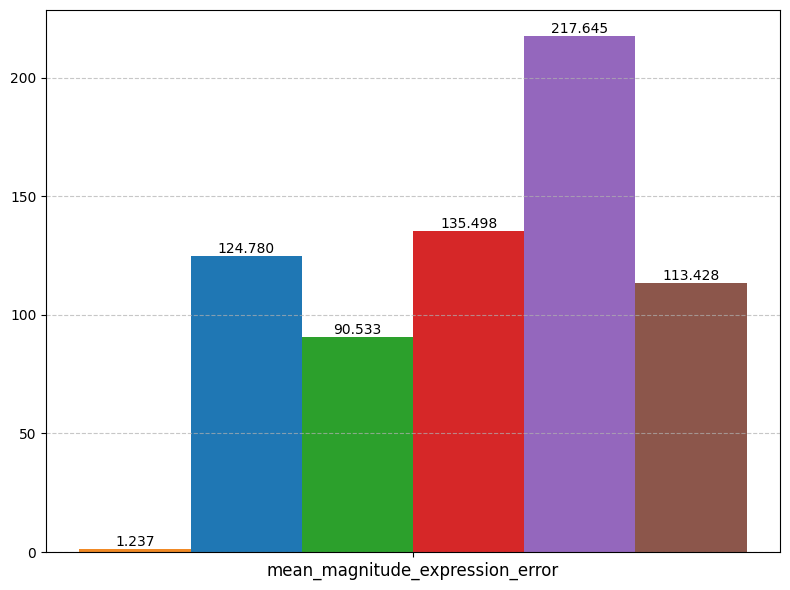

In [13]:
# plot_overall_metrics(metric_dict_collection, primary_metrics = ["accuracy", "sensitivity", "specificity"], secondary_metric = "mean_magnitude_expression_error", display_numbers=True, output_file = f"{fig2_output_dir}/overall_metrics.pdf")
plot_overall_metrics(metric_dict_collection, primary_metrics = ["accuracy", "sensitivity", "specificity"], display_numbers=True, display_numbers_fontsize=8, show_p_values = False, unique_mcrs_df = unique_mcrs_df, output_file = f"{fig2_output_dir}/overall_metrics_accuracy_sensitivity_specificity.pdf")  # output_file_p_values = f"{fig2_output_dir}/overall_metrics_acc_sens_spec_p_values.json"
plot_overall_metrics(metric_dict_collection, primary_metrics = ["f1_score", "recall", "precision"], display_numbers=True, display_numbers_fontsize=8, show_p_values = False, unique_mcrs_df = unique_mcrs_df, output_file = f"{fig2_output_dir}/overall_metrics_f1_recall_precision.pdf")  # output_file_p_values = f"{fig2_output_dir}/overall_metrics_acc_sens_spec_p_values.json"
# print_json(f"{fig2_output_dir}/overall_metrics_acc_sens_spec_p_values.json")

plot_overall_metrics(metric_dict_collection, primary_metrics = "mean_magnitude_expression_error", display_numbers=True, display_numbers_fontsize=10, show_p_values = False, unique_mcrs_df = unique_mcrs_df, output_file = f"{fig2_output_dir}/overall_metrics_error.pdf", filter_real_negatives = True)  # output_file_p_values = f"{fig2_output_dir}/overall_metrics_expression_error_p_values.json"
# print_json(f"{fig2_output_dir}/overall_metrics_expression_error_p_values.json")

# Number of detected reads for false positives

Text(0.5, 1.0, 'Histogram of AD_ALT_varseek where FP_varseek=True')

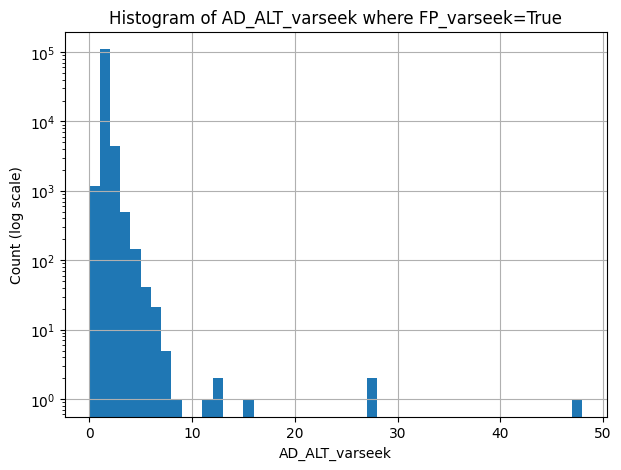

In [7]:
fp_df = unique_mcrs_df.loc[unique_mcrs_df["FP_varseek"], ["AD_ALT_varseek"]]

# hist() returns a 1-element array of Axes
axes = fp_df.hist(
    bins=range(
        int(fp_df["AD_ALT_varseek"].min()),
        int(fp_df["AD_ALT_varseek"].max()) + 2
    ),
    figsize=(7,5)
)

# Get the first Axes object
ax = axes[0,0]

# Now set scales and labels
ax.set_yscale("log")
ax.set_xlabel("AD_ALT_varseek")
ax.set_ylabel("Count (log scale)")
ax.set_title("Histogram of AD_ALT_varseek where FP_varseek=True")


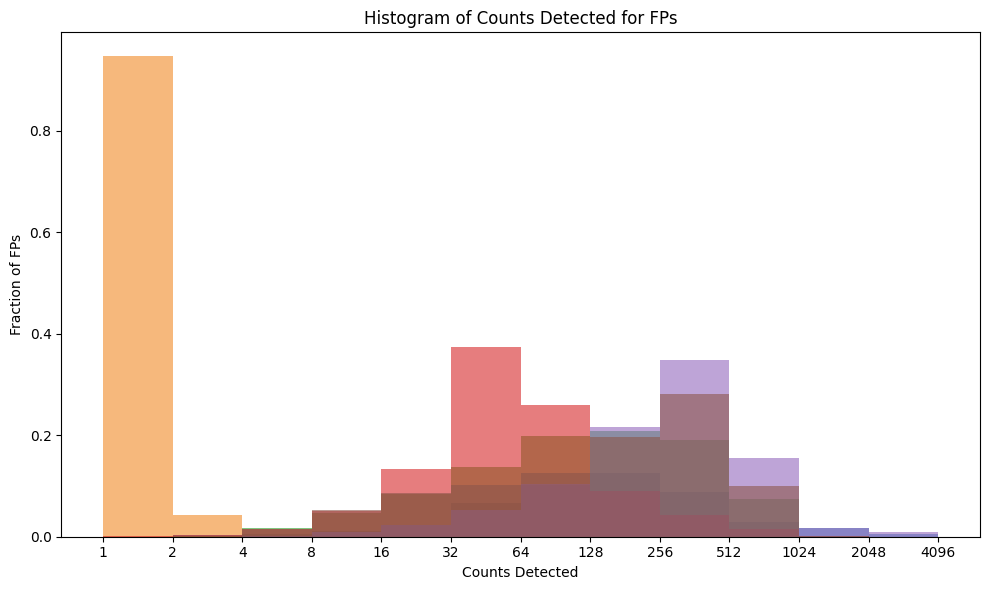

In [ ]:
plot_frequency_histogram(unique_mcrs_df, 'AD_ALT', tools, fraction=True, output_file = f"{fig2_output_dir}/AD_ALT_histogram.pdf")

# Stratified metric line plots

In [5]:
if "vcrs_variant_type" not in unique_mcrs_df.columns:
    unique_mcrs_df = add_vcrs_variant_type(unique_mcrs_df, var_column="vcrs_header")

substitution_df = unique_mcrs_df.loc[unique_mcrs_df["vcrs_variant_type"] == "substitution"]
indel_df = unique_mcrs_df.loc[unique_mcrs_df["vcrs_variant_type"] != "substitution"]
insertion_df = unique_mcrs_df.loc[unique_mcrs_df["vcrs_variant_type"].isin(["insertion", "duplication"])]
deletion_df = unique_mcrs_df.loc[unique_mcrs_df["vcrs_variant_type"] == "deletion"]
delins_df = unique_mcrs_df.loc[unique_mcrs_df["vcrs_variant_type"].isin(["delins", "inversion"])]

### Recall

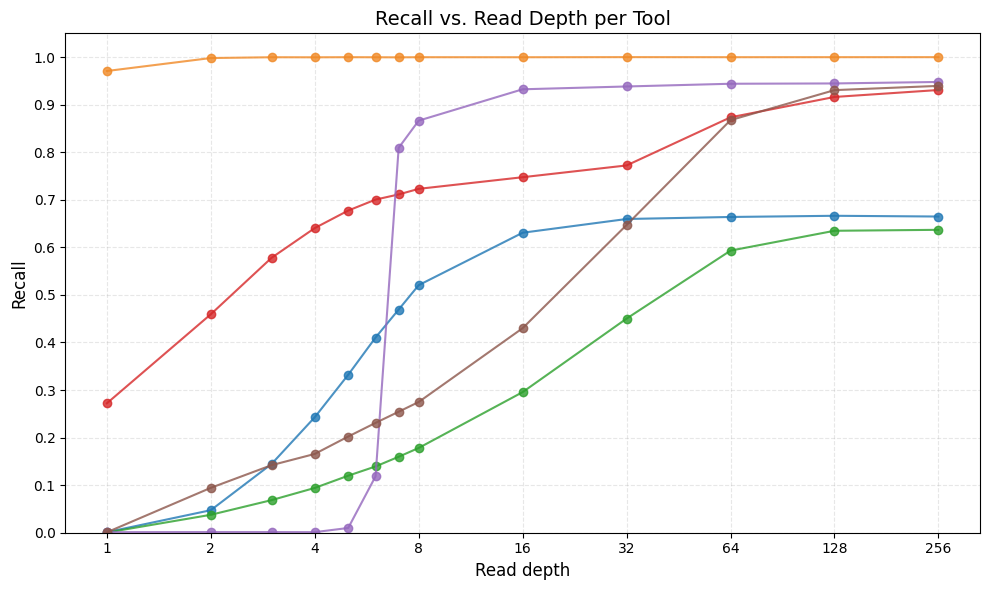

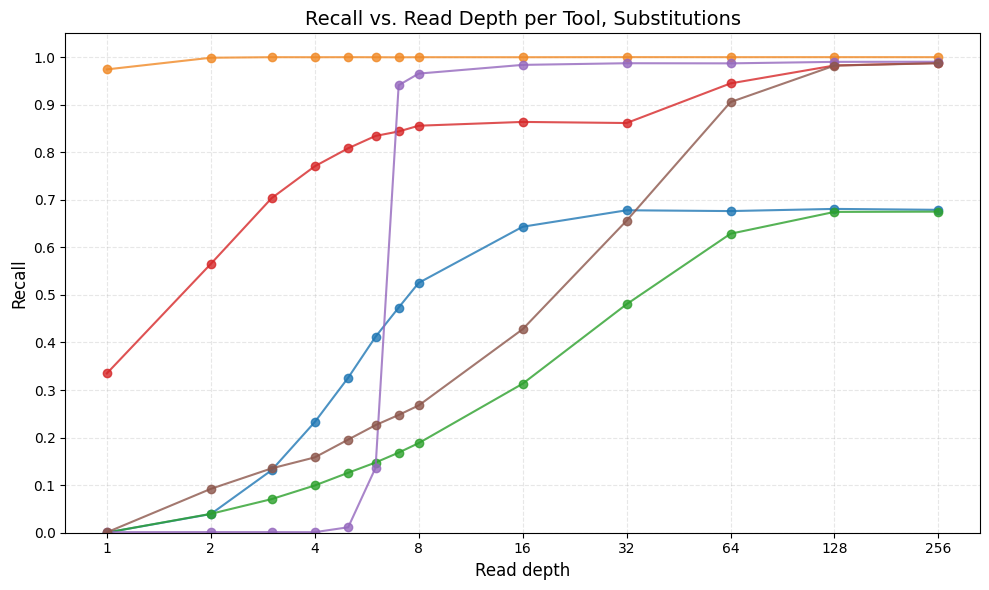

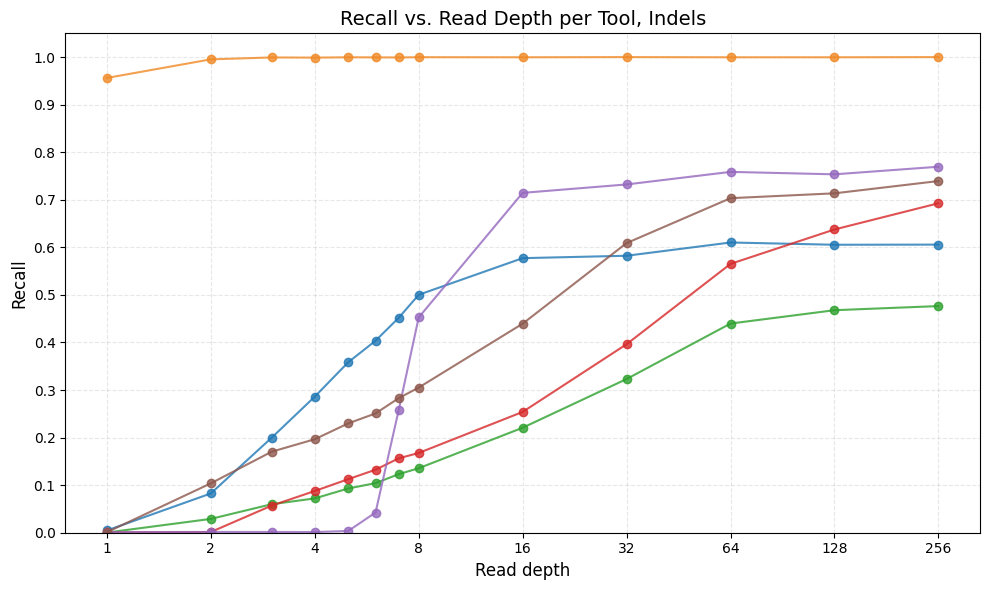

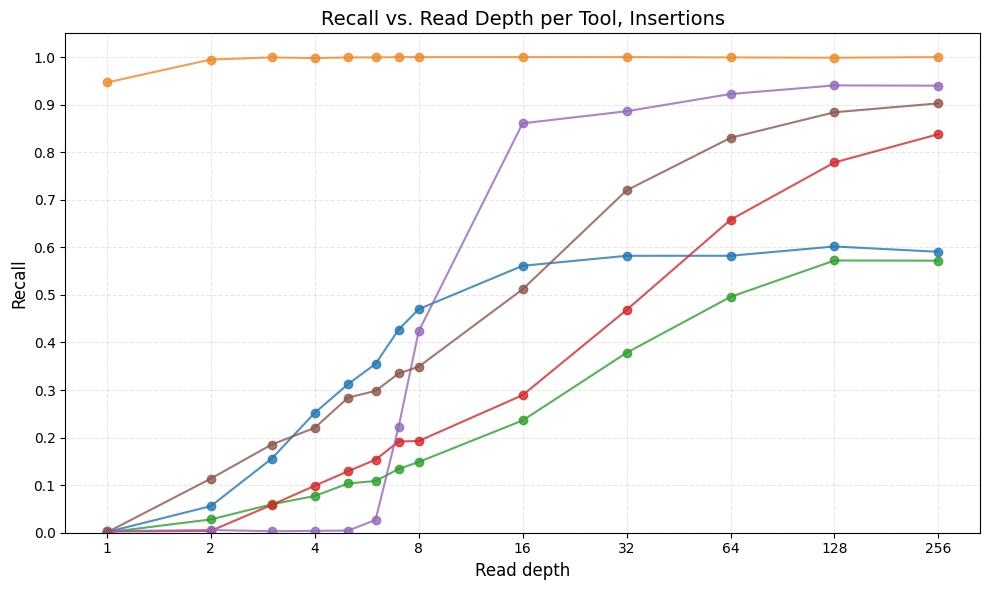

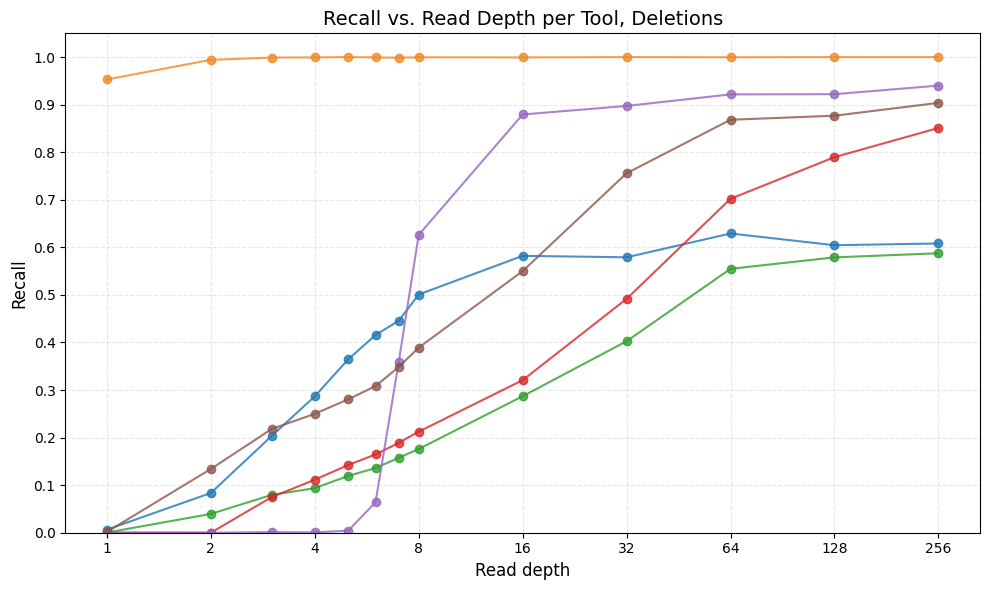

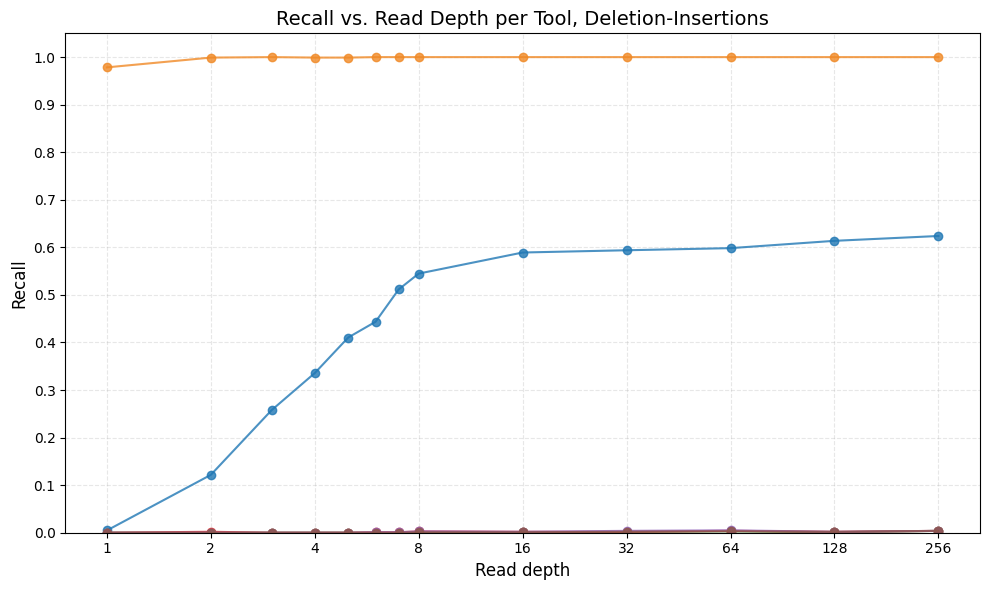

In [7]:
bins = [1, 2, 3, 4, 5, 6, 7, 8, 16, 32, 64, 128, 256]
x_log = True

plot_recall_stratified_by_depth(unique_mcrs_df, bins = bins, tools = tools, x_log = x_log, title = "Recall vs. Read Depth per Tool", output_file = f"{fig2_output_dir}/recall_vs_depth.pdf")
plot_recall_stratified_by_depth(substitution_df, bins = bins, tools = tools, x_log = x_log, title = "Recall vs. Read Depth per Tool, Substitutions", output_file = f"{fig2_output_dir}/recall_vs_depth_substitution_only.pdf")
plot_recall_stratified_by_depth(indel_df, bins = bins, tools = tools, x_log = x_log, title = "Recall vs. Read Depth per Tool, Indels", output_file = f"{fig2_output_dir}/recall_vs_depth_indel_only.pdf")
plot_recall_stratified_by_depth(insertion_df, bins = bins, tools = tools, x_log = x_log, title = "Recall vs. Read Depth per Tool, Insertions", output_file = f"{fig2_output_dir}/recall_vs_depth_insertion_only.pdf")
plot_recall_stratified_by_depth(deletion_df, bins = bins, tools = tools, x_log = x_log, title = "Recall vs. Read Depth per Tool, Deletions", output_file = f"{fig2_output_dir}/recall_vs_depth_deletion_only.pdf")
plot_recall_stratified_by_depth(delins_df, bins = bins, tools = tools, x_log = x_log, title = "Recall vs. Read Depth per Tool, Deletion-Insertions", output_file = f"{fig2_output_dir}/recall_vs_depth_delins_only.pdf")

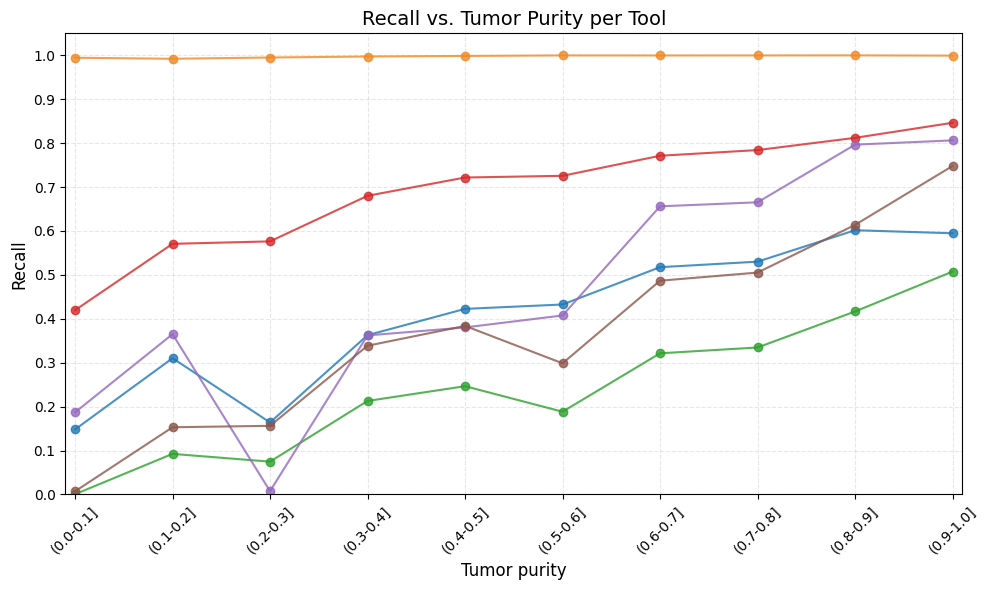

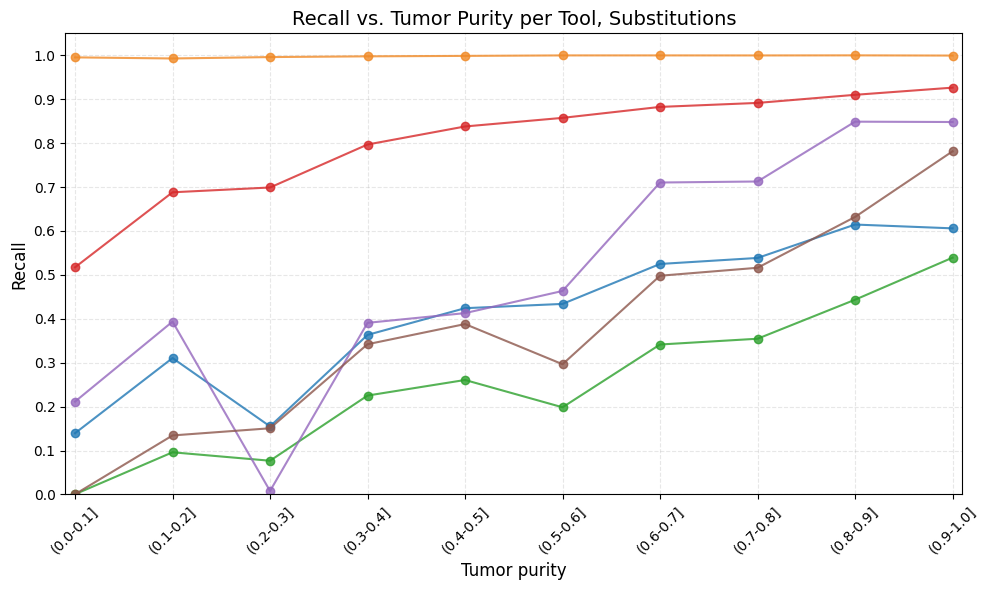

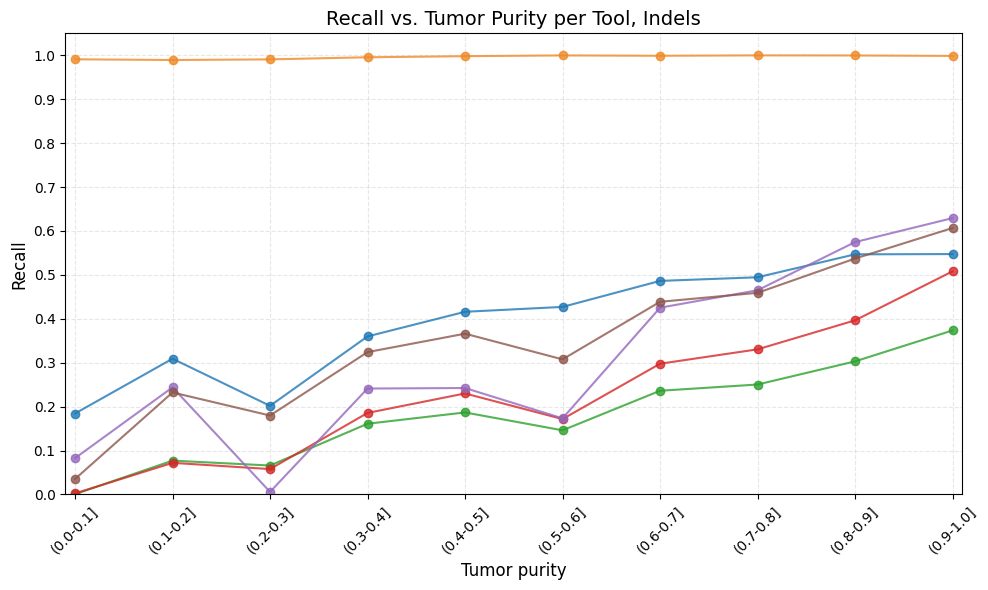

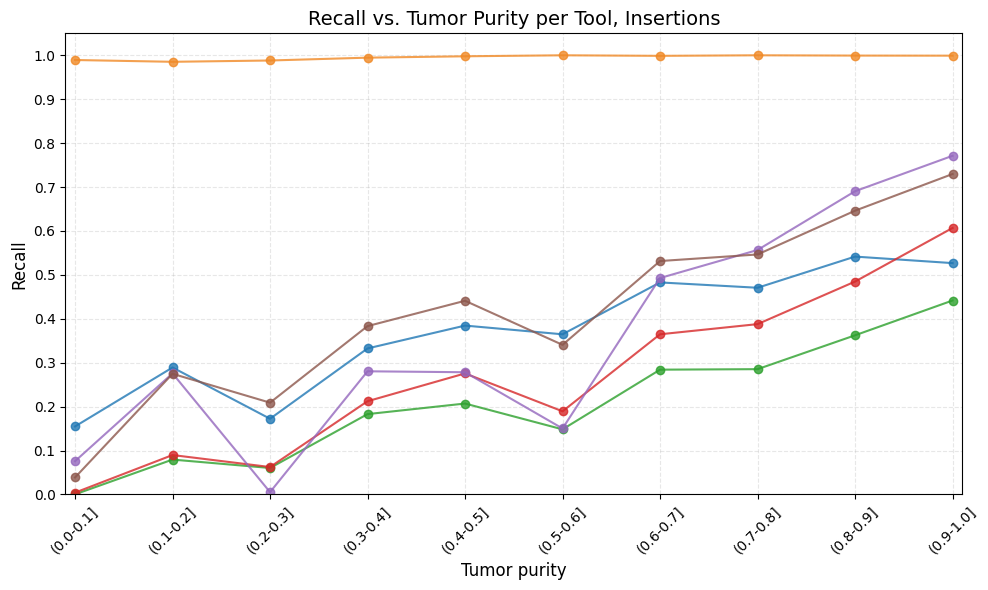

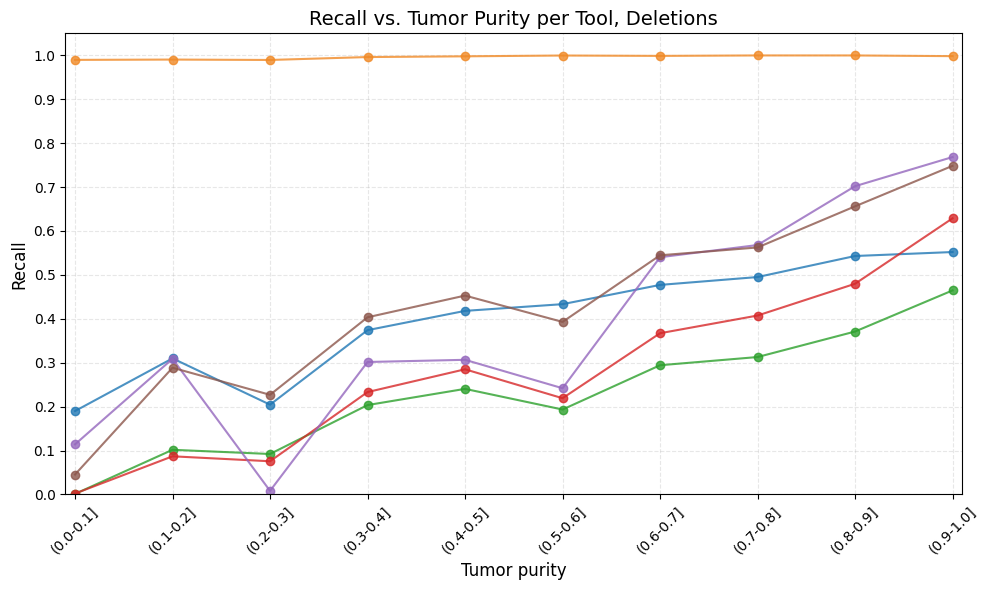

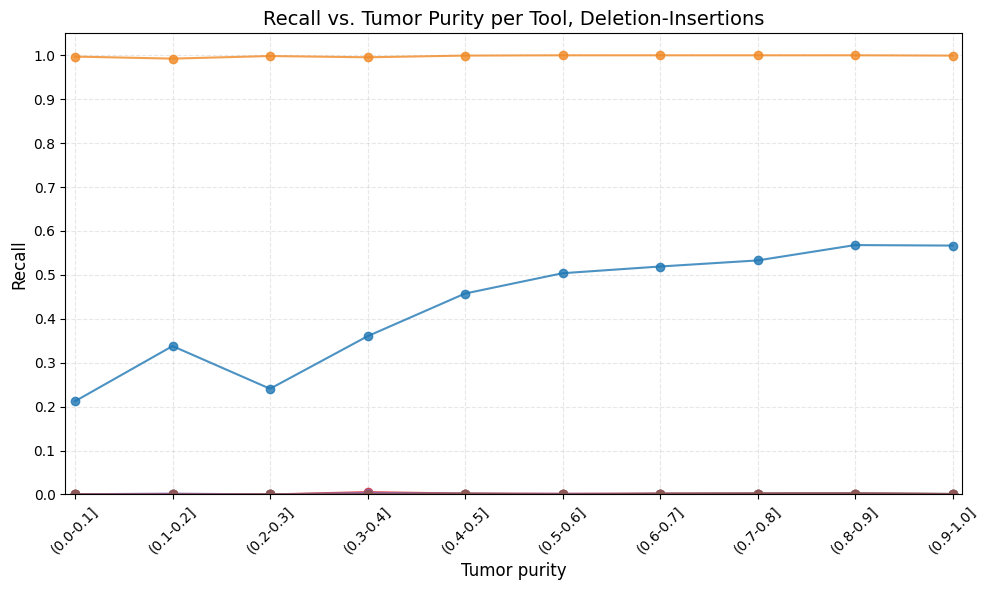

In [8]:
bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

plot_recall_stratified_by_tumor_purity(unique_mcrs_df, bins = bins, tools = tools, title = "Recall vs. Tumor Purity per Tool", output_file = f"{fig2_output_dir}/recall_vs_purity.pdf")
plot_recall_stratified_by_tumor_purity(substitution_df, bins = bins, tools = tools, title = "Recall vs. Tumor Purity per Tool, Substitutions", output_file = f"{fig2_output_dir}/recall_vs_purity_substitution_only.pdf")
plot_recall_stratified_by_tumor_purity(indel_df, bins = bins, tools = tools, title = "Recall vs. Tumor Purity per Tool, Indels", output_file = f"{fig2_output_dir}/recall_vs_purity_indel_only.pdf")
plot_recall_stratified_by_tumor_purity(insertion_df, bins = bins, tools = tools, title = "Recall vs. Tumor Purity per Tool, Insertions", output_file = f"{fig2_output_dir}/recall_vs_purity_insertion_only.pdf")
plot_recall_stratified_by_tumor_purity(deletion_df, bins = bins, tools = tools, title = "Recall vs. Tumor Purity per Tool, Deletions", output_file = f"{fig2_output_dir}/recall_vs_purity_deletion_only.pdf")
plot_recall_stratified_by_tumor_purity(delins_df, bins = bins, tools = tools, title = "Recall vs. Tumor Purity per Tool, Deletion-Insertions", output_file = f"{fig2_output_dir}/recall_vs_purity_delins_only.pdf")

### Precision

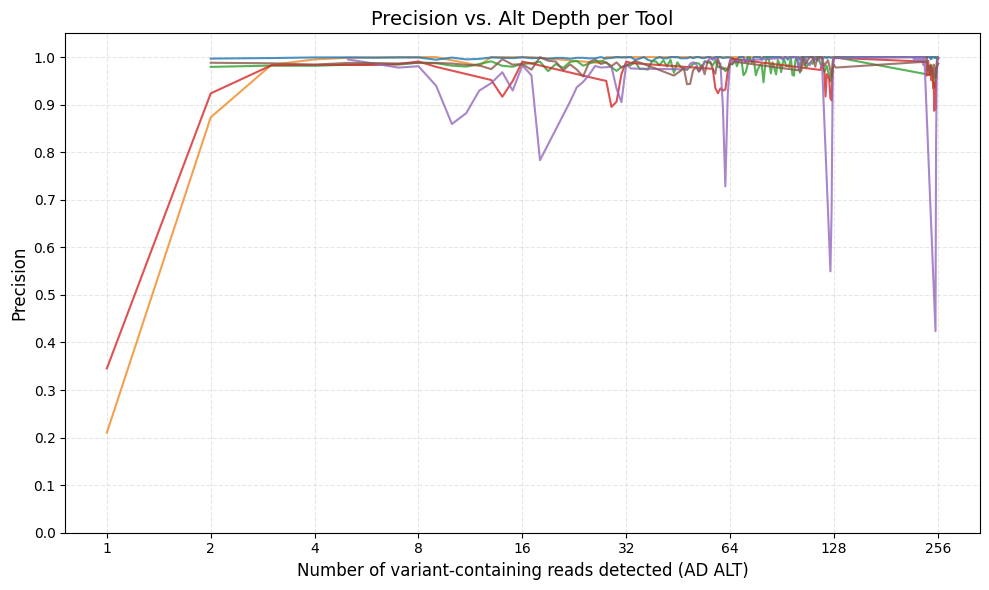

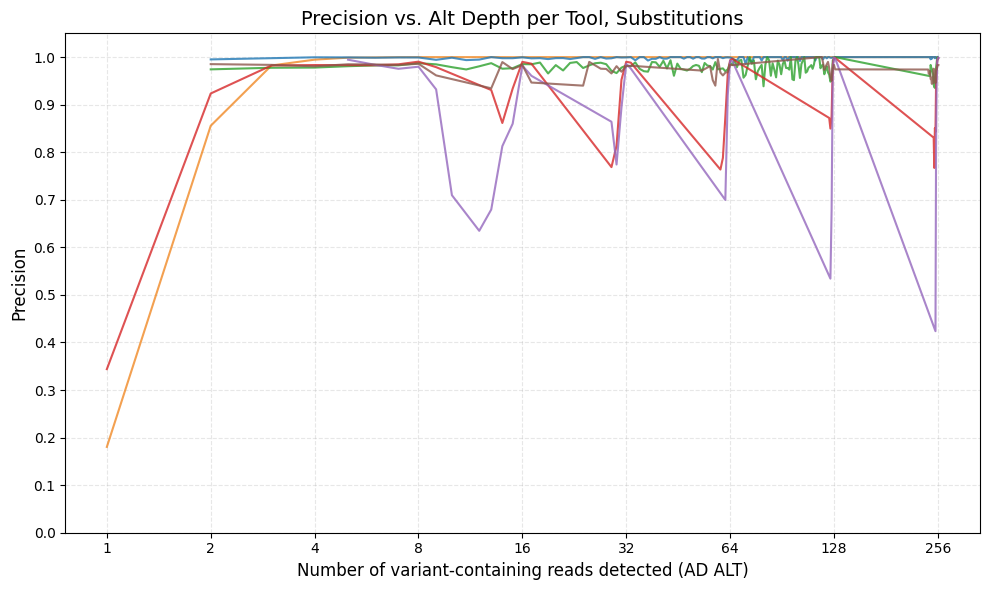

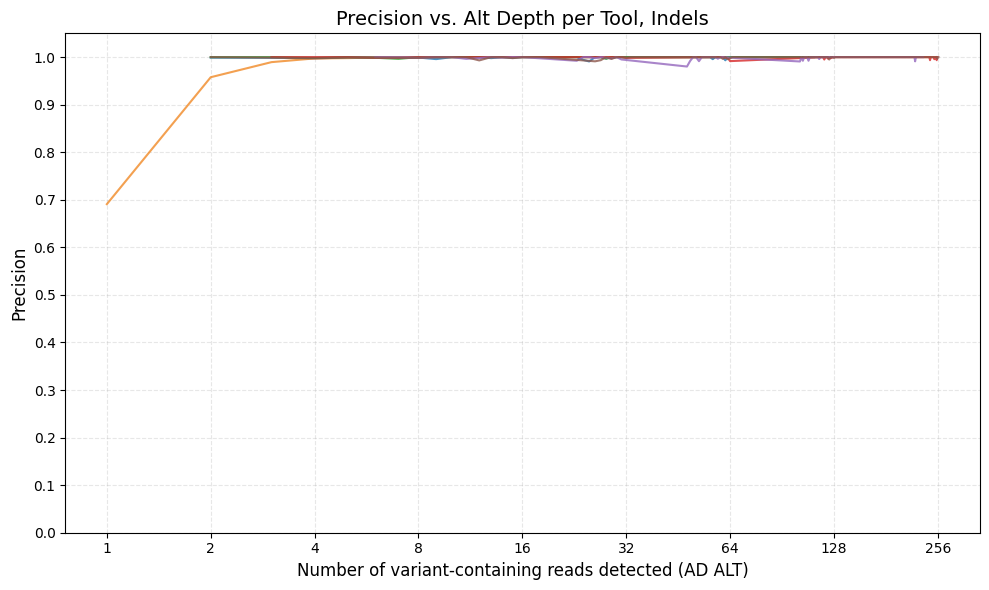

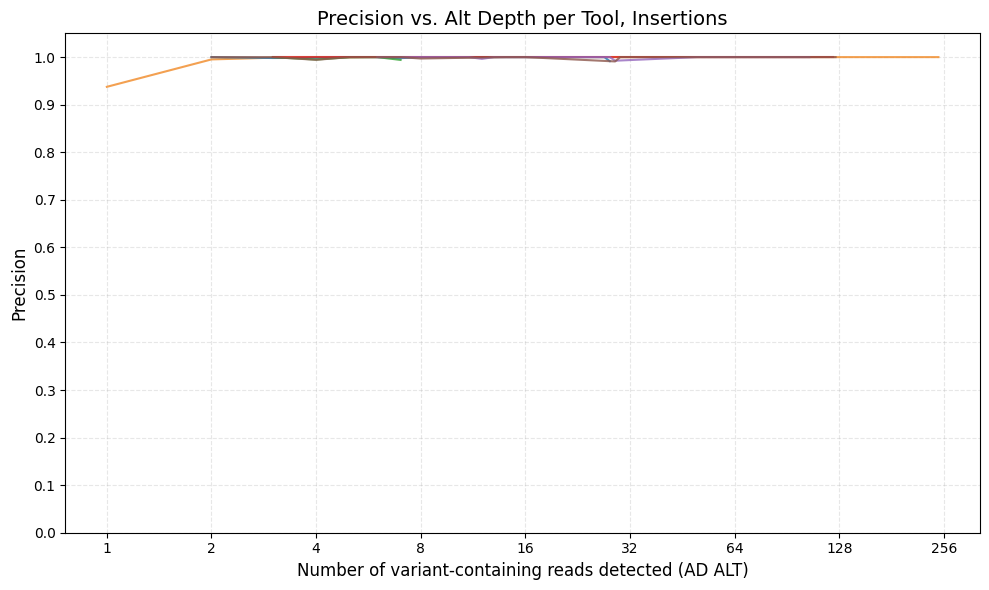

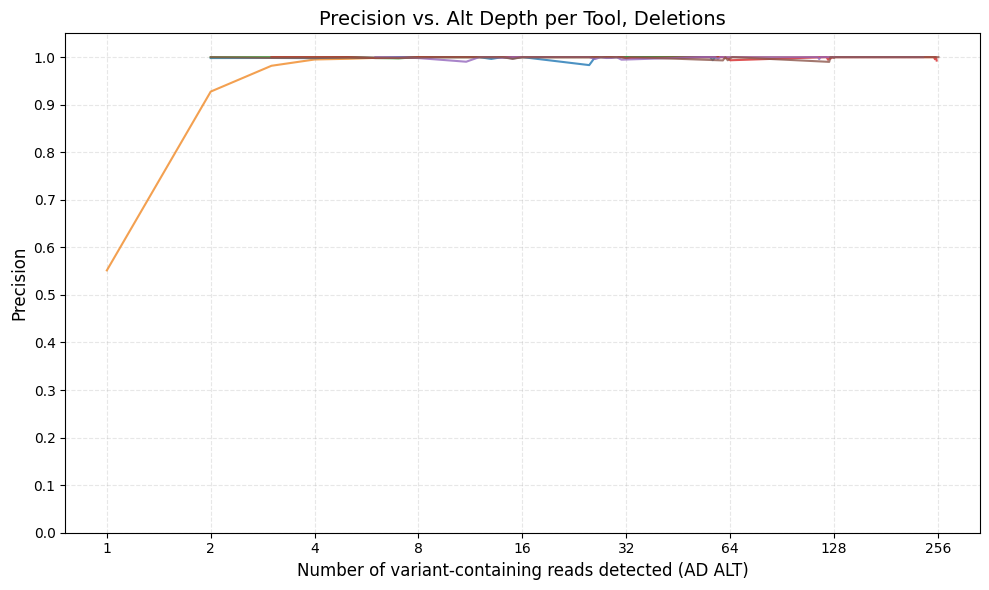

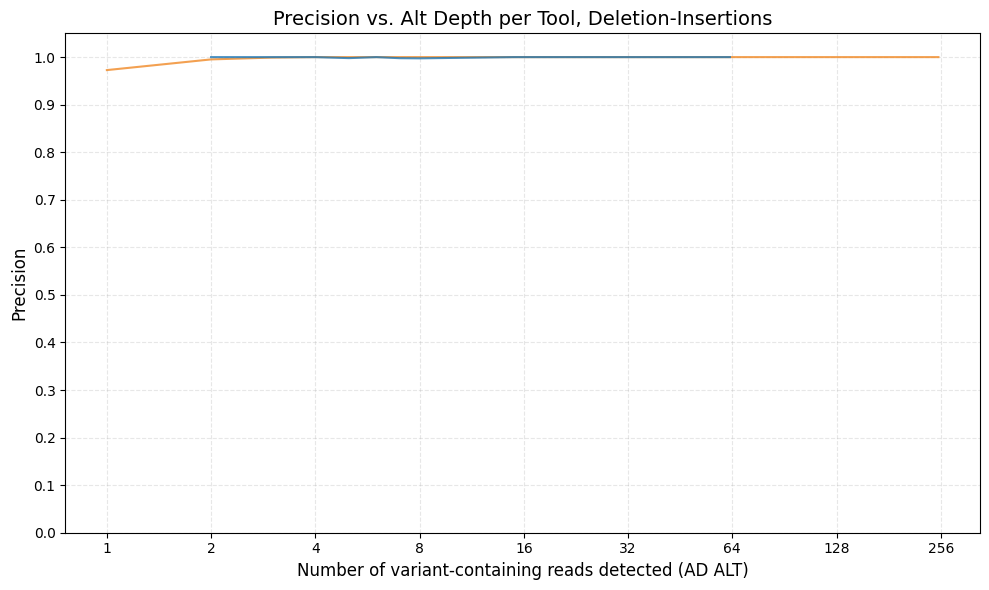

In [29]:
x_min = 1
x_max = 300
min_occurrences = 100
x_log = True

plot_precision_stratified_by_ad_alt(unique_mcrs_df, tools = tools, x_min = x_min, x_max = x_max, min_occurrences = min_occurrences, x_log = x_log, title = "Precision vs. Alt Depth per Tool", output_file = f"{fig2_output_dir}/precision_vs_AD_ALT.pdf")
plot_precision_stratified_by_ad_alt(substitution_df, tools = tools, x_min = x_min, x_max = x_max, min_occurrences = min_occurrences, x_log = x_log, title = "Precision vs. Alt Depth per Tool, Substitutions", output_file = f"{fig2_output_dir}/precision_vs_AD_ALT_substitution_only.pdf")
plot_precision_stratified_by_ad_alt(indel_df, tools = tools, x_min = x_min, x_max = x_max, min_occurrences = min_occurrences, x_log = x_log, title = "Precision vs. Alt Depth per Tool, Indels", output_file = f"{fig2_output_dir}/precision_vs_AD_ALT_indel_only.pdf")
plot_precision_stratified_by_ad_alt(insertion_df, tools = tools, x_min = x_min, x_max = x_max, min_occurrences = min_occurrences, x_log = x_log, title = "Precision vs. Alt Depth per Tool, Insertions", output_file = f"{fig2_output_dir}/precision_vs_AD_ALT_insertion_only.pdf")
plot_precision_stratified_by_ad_alt(deletion_df, tools = tools, x_min = x_min, x_max = x_max, min_occurrences = min_occurrences, x_log = x_log, title = "Precision vs. Alt Depth per Tool, Deletions", output_file = f"{fig2_output_dir}/precision_vs_AD_ALT_deletion_only.pdf")
plot_precision_stratified_by_ad_alt(delins_df, tools = tools, x_min = x_min, x_max = x_max, min_occurrences = min_occurrences, x_log = x_log, title = "Precision vs. Alt Depth per Tool, Deletion-Insertions", output_file = f"{fig2_output_dir}/precision_vs_AD_ALT_delins_only.pdf")

# Stratified metric line plot of all 3 methods: sensitivity vs mutant read depth

Log scale is set to True. Will remove all values <= 0 from the data for this plot.


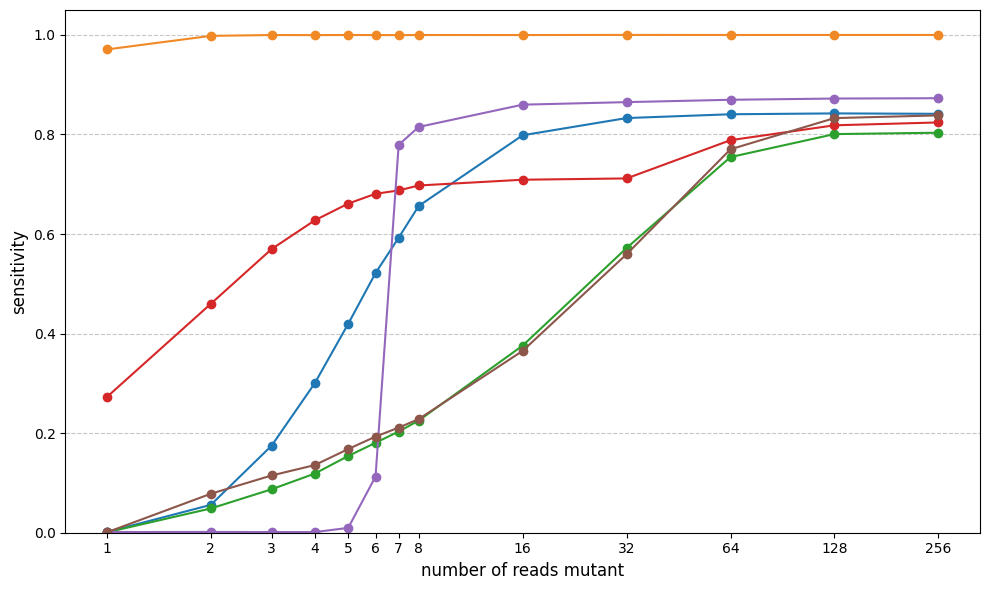

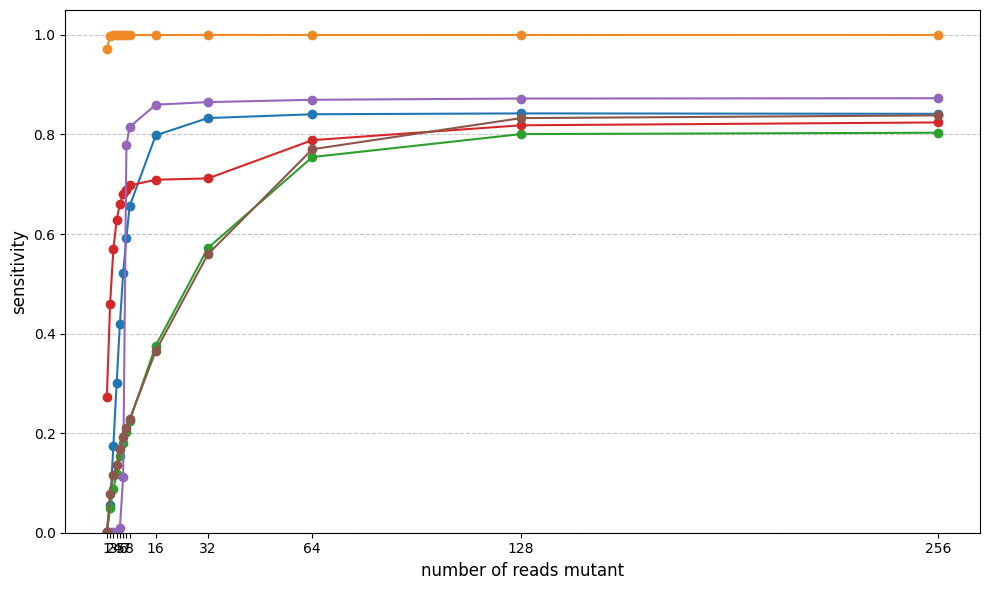

In [ ]:
x_stratification = "number_of_reads_mutant"
y_metric = "sensitivity"
bins, keep_strict_bins = [3, 4, 5, 6, 7, 8, 16, 32, 64, 128, 256], True
# bins, keep_strict_bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 16, 32, 64, 128, float('inf')], False  # uncomment for the binned appearance
create_stratified_metric_line_plot(unique_mcrs_df, tools = tools, x_stratification = x_stratification, y_metric = y_metric, bins = bins, keep_strict_bins = keep_strict_bins, show_p_values = False, output_file = f"{fig2_output_dir}/{y_metric}_vs_{x_stratification}.pdf", filter_real_negatives = True, log=True)   # output_file_p_values = f"{fig2_output_dir}/{y_metric}_vs_{x_stratification}_p_values.txt"
create_stratified_metric_line_plot(unique_mcrs_df, tools = tools, x_stratification = x_stratification, y_metric = y_metric, bins = bins, keep_strict_bins = keep_strict_bins, show_p_values = False, output_file = f"{fig2_output_dir}/{y_metric}_vs_{x_stratification}_unlogged.pdf", filter_real_negatives = True, log=False)   # output_file_p_values = f"{fig2_output_dir}/{y_metric}_vs_{x_stratification}_p_values.txt"

Log scale is set to True. Will remove all values <= 0 from the data for this plot.


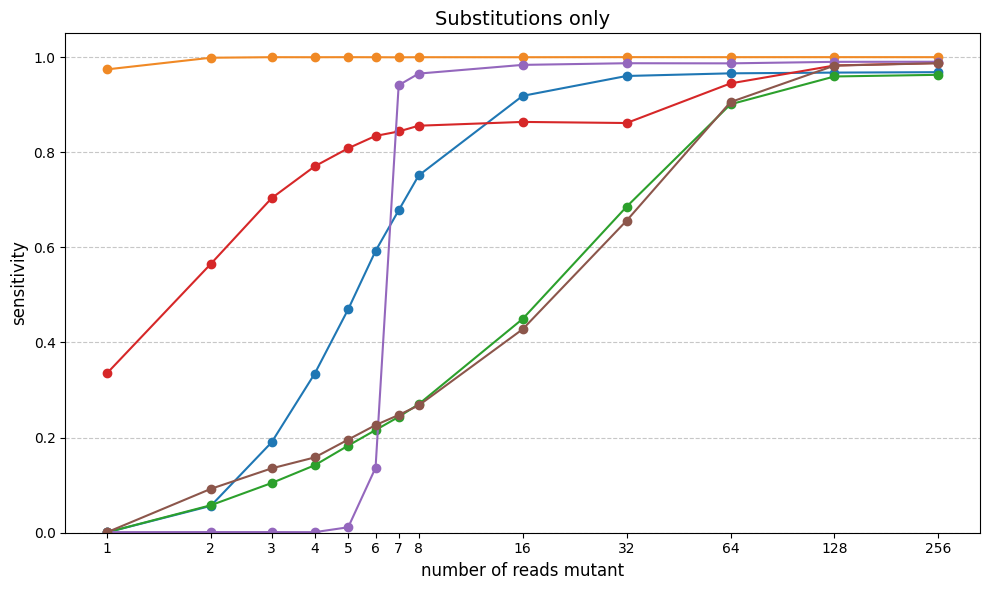

Log scale is set to True. Will remove all values <= 0 from the data for this plot.


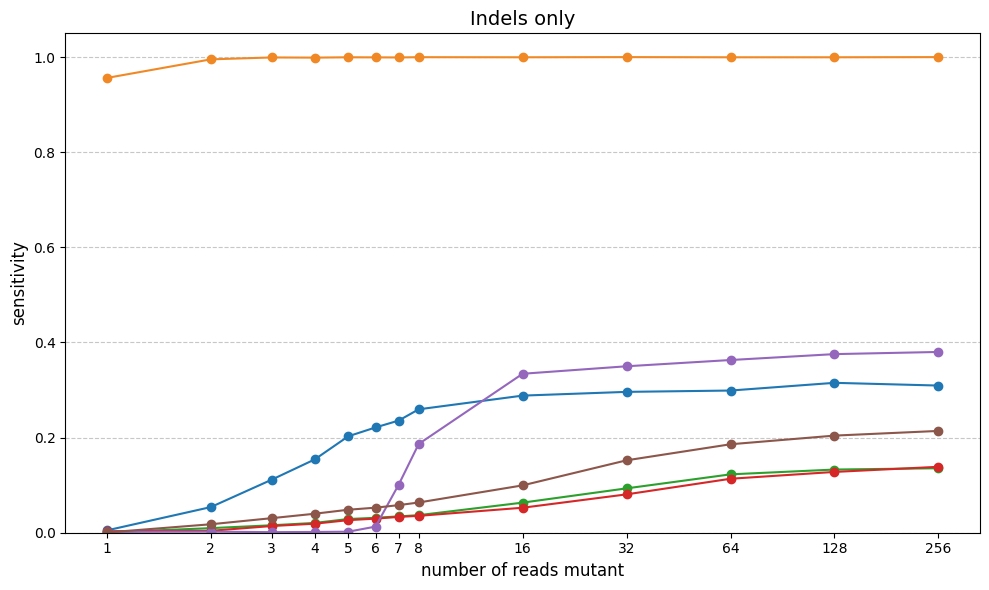

In [ ]:
x_stratification = "number_of_reads_mutant"
y_metric = "sensitivity"
bins, keep_strict_bins = [3, 4, 5, 6, 7, 8, 16, 32, 64, 128, 256], True

create_stratified_metric_line_plot(substitution_df, tools = tools, x_stratification = x_stratification, y_metric = y_metric, bins = bins, keep_strict_bins = keep_strict_bins, show_p_values = False, output_file = f"{fig2_output_dir}/{y_metric}_vs_{x_stratification}_substitution.pdf", filter_real_negatives = True, log=True, title="Substitutions only")   # output_file_p_values = f"{fig2_output_dir}/{y_metric}_vs_{x_stratification}_p_values.txt"
create_stratified_metric_line_plot(indel_df, tools = tools, x_stratification = x_stratification, y_metric = y_metric, bins = bins, keep_strict_bins = keep_strict_bins, show_p_values = False, output_file = f"{fig2_output_dir}/{y_metric}_vs_{x_stratification}_indel.pdf", filter_real_negatives = True, log=True, title="Indels only")   # output_file_p_values = f"{fig2_output_dir}/{y_metric}_vs_{x_stratification}_p_values.txt"

# Stratified metric line plot of all 3 methods: sensitivity vs tumor purity

/home/jmrich/Desktop/RLSRWP_2025/RLSRWP_2025/visualization_utils.py:586: RuntimeWarning: invalid value encountered in remainder
  if np.all(np.equal(np.mod(bins, 1), 0)):  # if all bin values are integers, then display x-axis as integers


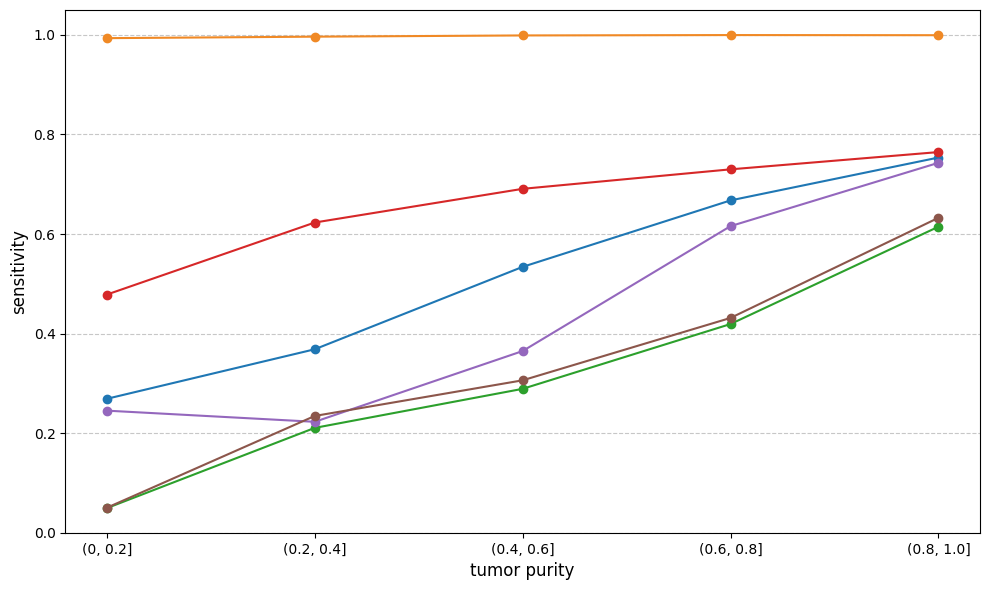

In [18]:
x_stratification = "tumor_purity"
y_metric = "sensitivity"
bins = [0, 0.2, 0.4, 0.6, 0.8, float('inf')]  # bins = None  # bins = [0, 0.25, 0.5, 0.75, 1]  # [-float('inf'), 0.25, 0.5, 0.75, float('inf')]  # absolute lower bound, midpoint1, midpoint2, ..., absolute upper bound - eg bins [0, 0.25, 0.5, 0.75, 1] --> labels ["(0, 0.25]", "(0.25, 0.5]", "(0.5, 0.75]", "(0.75, 1]"] - if absolute lower bound provided is less than real absolute lower bound, then just use -float(inf) and it is replaced internally (and same for upper)
create_stratified_metric_line_plot(unique_mcrs_df, tools = tools, x_stratification = x_stratification, y_metric = y_metric, bins = bins, show_p_values = False, output_file = f"{fig2_output_dir}/{y_metric}_vs_{x_stratification}.pdf")   # f"{fig2_output_dir}/{y_metric}_vs_{x_stratification}_p_values.txt"

# Stratified metric line plot of all 3 methods: mean_magnitude_expression_error vs mutant sequencing depth

Log scale is set to True. Will remove all values <= 0 from the data for this plot.


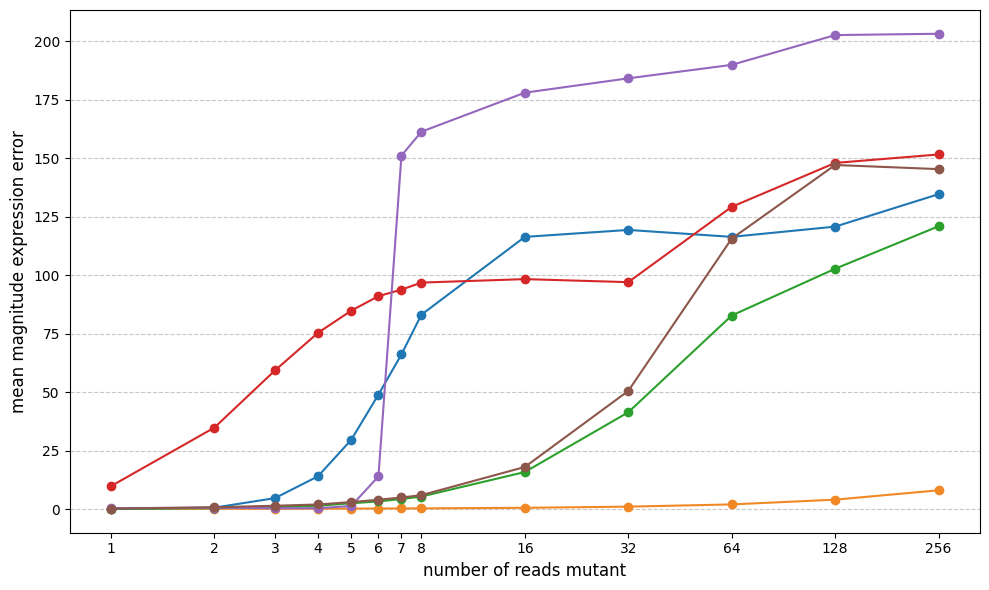

In [ ]:
x_stratification = "number_of_reads_mutant"
y_metric = "mean_magnitude_expression_error"  # mean_magnitude_expression_error or mean_expression_error
bins, keep_strict_bins = [3, 4, 5, 6, 7, 8, 16, 32, 64, 128, 256], True
filter_real_negatives = False  # set this to True when y_metric is expression error for all cases besides x_stratification = "number_of_reads_mutant", as we are not interested in the vast majority of cases that are real 0 and predicted 0
create_stratified_metric_line_plot(unique_mcrs_df, tools = tools, x_stratification = x_stratification, y_metric = y_metric, bins=bins, keep_strict_bins=keep_strict_bins, filter_real_negatives = filter_real_negatives, show_p_values = False, show_confidence_intervals = False, output_file = f"{fig2_output_dir}/{y_metric}_vs_{x_stratification}.pdf", output_file_p_values = None, log=True)   # f"{fig2_output_dir}/{y_metric}_vs_{x_stratification}_p_values.txt"

# Stratified metric bar plot of all 3 methods: sensitivity vs mutation type

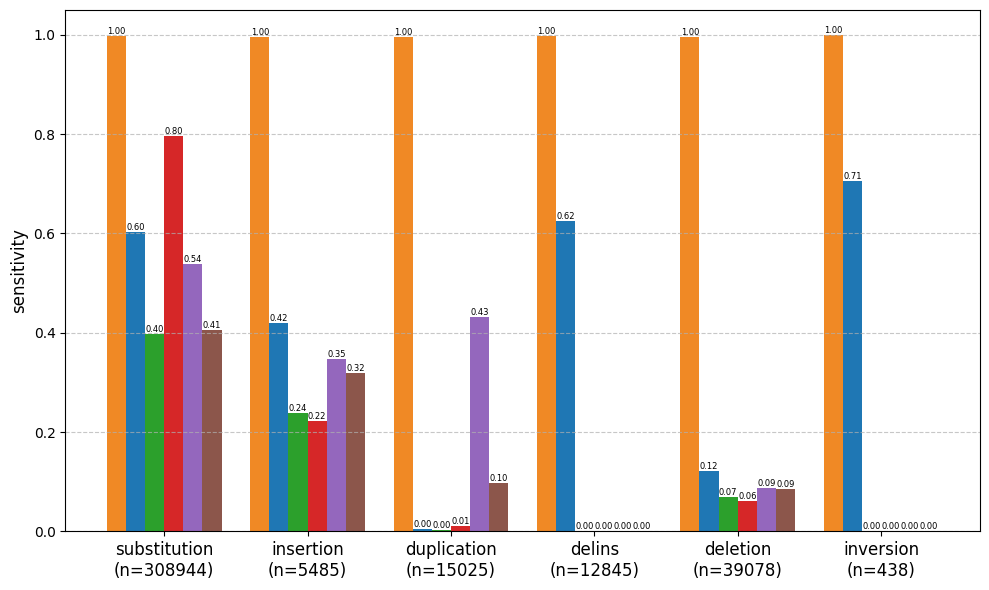

In [ ]:
if "vcrs_variant_type" not in unique_mcrs_df.columns:
    unique_mcrs_df = add_vcrs_variant_type(unique_mcrs_df, var_column="vcrs_header")

x_stratification = "vcrs_variant_type"
y_metric = "sensitivity"
create_stratified_metric_bar_plot_updated(unique_mcrs_df, tools = tools, x_stratification = x_stratification, y_metric = y_metric, display_numbers = True, display_numbers_fontsize=6, show_sample_size_per_x_value=True, show_p_values = False, output_file = f"{fig2_output_dir}/{y_metric}_vs_{x_stratification}.pdf")

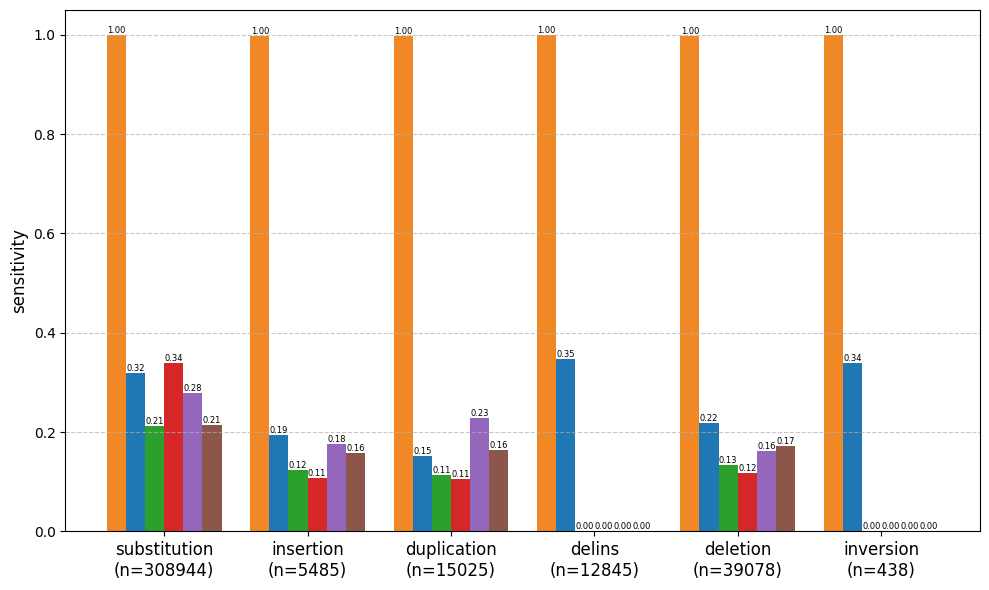

In [15]:
if "vcrs_variant_type" not in unique_mcrs_df.columns:
    unique_mcrs_df = add_vcrs_variant_type(unique_mcrs_df, var_column="vcrs_header")

x_stratification = "vcrs_variant_type"
y_metric = "sensitivity"
create_stratified_metric_bar_plot_updated(unique_mcrs_df, tools = tools, x_stratification = x_stratification, y_metric = y_metric, display_numbers = True, display_numbers_fontsize=6, show_sample_size_per_x_value=True, show_p_values = False, output_file = f"{fig2_output_dir}/{y_metric}_vs_{x_stratification}.pdf")

# Stratified metric bar plot of all 3 methods: mean mutation expression error vs mutation type

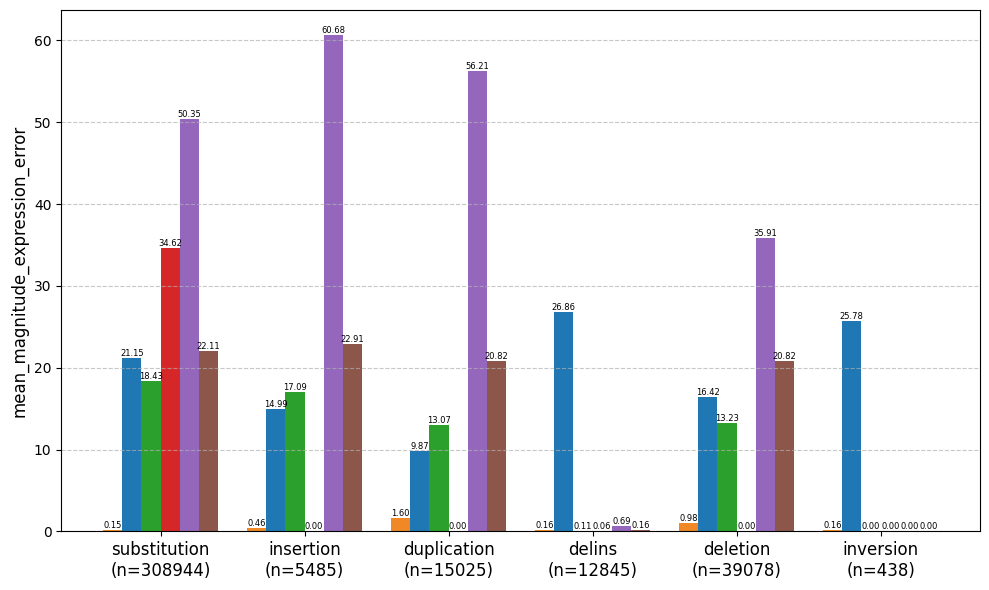

In [16]:
x_stratification = "vcrs_variant_type"
y_metric = "mean_magnitude_expression_error"  # mean_magnitude_expression_error or mean_expression_error
filter_real_negatives = True
create_stratified_metric_bar_plot_updated(unique_mcrs_df, tools = tools, x_stratification = x_stratification, y_metric = y_metric, display_numbers = True, display_numbers_fontsize=6, show_sample_size_per_x_value=True, show_p_values = False, filter_real_negatives = filter_real_negatives, output_file = f"{fig2_output_dir}/{y_metric}_vs_{x_stratification}.pdf")   # f"{fig2_output_dir}/{y_metric}_vs_{x_stratification}_p_values.txt"

## Time and memory plot

### Put data in a df

In [11]:
# Regex patterns
runtime_pattern = re.compile(r"([\w\s]+)\s(\d+)\sreads\s\d+\sthreads\sRuntime:\s(\d+(?:\.\d+)?)\sminutes,\s([\d.]+)\sseconds")
memory_pattern = re.compile(r"([\w\s]+)\s(\d+)\sreads\s\d+\sthreads\sPeak memory usage:\s([\d.]+)\s(GB|MB)")

data = []

# Read file and extract information
with open(variant_calling_stats_file, "r") as f:
    for line in f:
        # Extract runtime
        runtime_match = runtime_pattern.match(line)
        if runtime_match:
            tool, reads, minutes, seconds = runtime_match.groups()
            runtime = round((int(float(minutes)) * 60 + float(seconds)) / 60, 2)  # units: minutes
            data.append({"Tool": tool, "Reads": int(reads), "Metric": "Runtime", "Value_variant_calling": runtime, "Extrapolated": False})

        # Extract memory usage
        memory_match = memory_pattern.match(line)
        if memory_match:
            tool, reads, mem_value, unit = memory_match.groups()
            memory = round(float(mem_value) if unit == "GB" else float(mem_value) / 1024, 2)  # units: GB
            data.append({"Tool": tool, "Reads": int(reads), "Metric": "Memory", "Value_variant_calling": memory, "Extrapolated": False})

# Convert to DataFrame
time_and_memory_df = pd.DataFrame(data)
print("Units: minutes for runtime, GB for memory")
time_and_memory_df.head()

Units: minutes for runtime, GB for memory


Tool    Reads   Metric  Value_variant_calling  Extrapolated
0               varseek  1000000  Runtime                   1.91         False
1               varseek  1000000   Memory                   4.02         False
2  gatk_haplotypecaller  1000000  Runtime                  29.64         False
3  gatk_haplotypecaller  1000000   Memory                  12.00         False
4          gatk_mutect2  1000000  Runtime                  36.26         False

## Fill in missing data by extrapolating best fit lines

In [12]:
def fit_func(x, a, b):
    return a * x**b  # Power law fit

# Identify unique values of Reads
unique_reads = time_and_memory_df["Reads"].unique()

# Function to handle missing values for a given tool
def extrapolate_missing_runtime(tool):
    updated_df = time_and_memory_df.copy()  # Make a copy to modify

    for metric in ["Runtime", "Memory"]:
        # Filter for the tool and metric
        df_tool = updated_df[
            (updated_df["Tool"] == tool) & (updated_df["Metric"] == metric)
        ]

        # Extract Reads and corresponding metric values
        available_reads = df_tool["Reads"].values
        metric_values = df_tool["Value_variant_calling"].values

        # Identify missing read values
        missing_reads = set(unique_reads) - set(available_reads)

        if missing_reads and len(available_reads) > 1:  # Ensure enough points to fit
            try:
                # Fit a curve to the available data
                popt, _ = curve_fit(fit_func, available_reads, metric_values)

                # Predict missing values
                missing_predictions = {r: fit_func(r, *popt) for r in missing_reads}

                # Create a DataFrame of missing values
                missing_df = pd.DataFrame({
                    "Tool": tool,
                    "Reads": list(missing_predictions.keys()),
                    "Metric": metric,
                    "Value_variant_calling": list(missing_predictions.values()),
                    "Extrapolated": True
                })

                # Append to the DataFrame
                updated_df = pd.concat([updated_df, missing_df], ignore_index=True)
            
            except RuntimeError:
                print(f"Curve fitting failed for {tool}, {metric} due to insufficient or poor data.")

    return updated_df  # Return updated DataFrame after processing both metrics

# Apply the function for each unique tool
for tool in time_and_memory_df["Tool"].unique():
    time_and_memory_df = extrapolate_missing_runtime(tool)

# Convert Tool and Metric to categorical with specified order
time_and_memory_df["Tool"] = pd.Categorical(time_and_memory_df["Tool"], categories=tools, ordered=True)
time_and_memory_df["Metric"] = pd.Categorical(time_and_memory_df["Metric"], categories=["Runtime", "Memory"], ordered=True)

# Sort by Reads, then Tool (custom order), then Metric (custom order)
time_and_memory_df = time_and_memory_df.sort_values(by=["Reads", "Tool", "Metric"]).reset_index(drop=True)

## Load in STAR data

In [13]:
# Data storage
data = []

# Regex pattern to extract relevant fields
bam_runtime_pattern = re.compile(r"BAM indexing runtime(?:\s\(aligned and unmapped, for GATK\))? for (\d+) reads: (\d+)\.0 minutes, ([\d.]+) seconds")

# Read and process the file
with open(STAR_stats_file, "r") as f:
    for line in f:
        # Extract STAR alignment runtime
        match = runtime_pattern.match(line)
        if match:
            tool, reads, minutes, seconds = match.groups()
            runtime = round((int(float(minutes)) * 60 + float(seconds)) / 60, 2)  # units: minutes
            data.append({"Tool": "STAR", "Reads": int(reads), "Metric": "Runtime", "Value_alignment": runtime})

        # Extract memory usage
        memory_match = memory_pattern.match(line)
        if memory_match:
            tool, reads, mem_value, unit = memory_match.groups()
            memory = round(float(mem_value) if unit == "GB" else float(mem_value) / 1024, 2)  # units: GB
            data.append({"Tool": "STAR", "Reads": int(reads), "Metric": "Memory", "Value_alignment": memory})
        
        # Extract BAM indexing runtime (ignore "aligned-only, for non-GATK")
        match = bam_runtime_pattern.match(line)
        if match:
            reads, minutes, seconds = match.groups()
            runtime = round((int(float(minutes)) * 60 + float(seconds)) / 60, 2)  # units: minutes
            data.append({"Tool": "BAM indexing", "Reads": int(reads), "Metric": "Runtime", "Value_alignment": runtime})

# Convert to DataFrame
star_time_and_memory_df = pd.DataFrame(data)

# Aggregate across Tools that share the same Reads and Metric
star_time_and_memory_df = star_time_and_memory_df.groupby(["Reads", "Metric"], as_index=False).agg({"Value_alignment": "sum"})

print("Units: minutes for runtime, GB for memory")
star_time_and_memory_df.head()

Units: minutes for runtime, GB for memory


Reads   Metric  Value_alignment
0   1000000   Memory            34.64
1   1000000  Runtime             2.34
2   4000000   Memory            34.70
3   4000000  Runtime             2.77
4  16000000   Memory            34.88

### Notice how STAR alignments are pretty consistent in RAM requirements across reads

In [14]:
print(star_time_and_memory_df.loc[star_time_and_memory_df["Metric"] == "Memory"])
star_alignment_memory_mean = star_time_and_memory_df.loc[star_time_and_memory_df["Metric"] == "Memory", "Value_alignment"].mean()

         Reads  Metric  Value_alignment
0      1000000  Memory            34.64
2      4000000  Memory            34.70
4     16000000  Memory            34.88
6     64000000  Memory            35.13
8    256000000  Memory            35.11
10  1024000000  Memory            35.35


In [15]:
# Merge the STAR + BAM indexing DataFrame with time_and_memory_df
time_and_memory_df = time_and_memory_df.merge(star_time_and_memory_df, on=["Reads", "Metric"], how="left")

# Set varseek rows to 0, since varseek doesn't utilize STAR
time_and_memory_df.loc[time_and_memory_df["Tool"] == "varseek", "Value_alignment"] = 0

time_and_memory_df.loc[time_and_memory_df["Metric"] == "Runtime", "Value_total"] = (time_and_memory_df["Value_alignment"] + time_and_memory_df["Value_variant_calling"])  # for runtime, sum
time_and_memory_df.loc[time_and_memory_df["Metric"] == "Memory", "Value_total"] = time_and_memory_df.loc[time_and_memory_df["Metric"] == "Memory", "Value_variant_calling"] # time_and_memory_df.loc[time_and_memory_df["Metric"] == "Memory", "Value_total"] = (time_and_memory_df[["Value_alignment", "Value_variant_calling"]].max(axis=1))  # for memory, take the max
time_and_memory_df.head()

Tool    Reads   Metric  Value_variant_calling  \
0               varseek  1000000  Runtime                   1.91   
1               varseek  1000000   Memory                   4.02   
2          gatk_mutect2  1000000  Runtime                  36.26   
3          gatk_mutect2  1000000   Memory                  11.80   
4  gatk_haplotypecaller  1000000  Runtime                  29.64   

   Extrapolated  Value_alignment  Value_total  
0         False             0.00         1.91  
1         False             0.00         4.02  
2         False             2.34        38.60  
3         False            34.64        11.80  
4         False             2.34        31.98

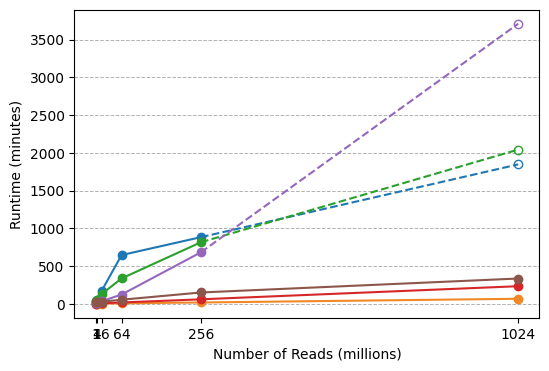

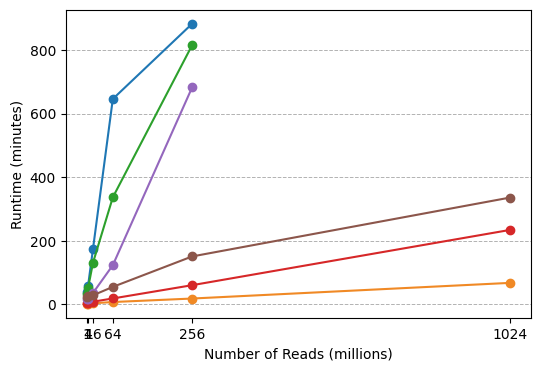

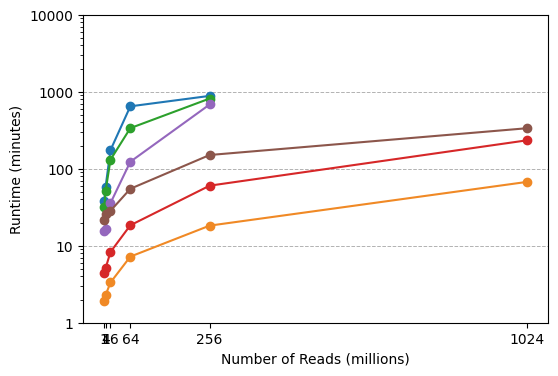

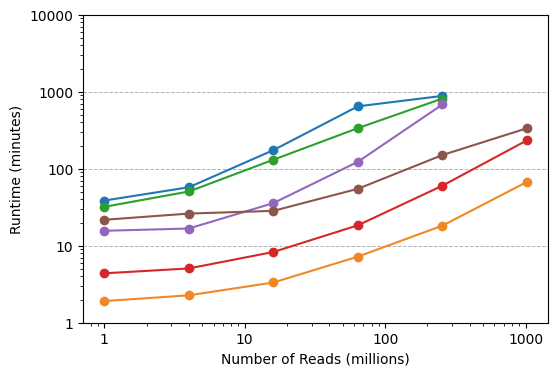

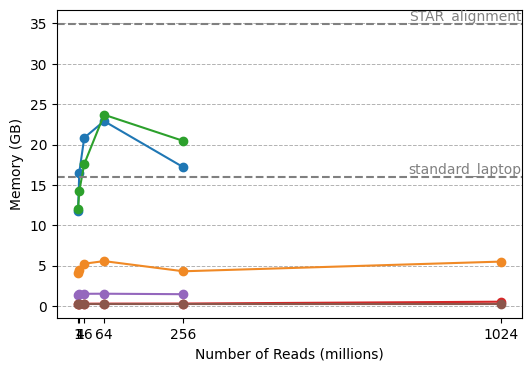

In [ ]:
# from RLSRWP_2025.visualization_utils import plot_time_and_memory_benchmarking
plot_time_and_memory_benchmarking(time_and_memory_df, metric_name = "Runtime", units="minutes", y_col="Value_total", plot_extrapolated=True, output_file = f"{fig2_output_dir}/runtime_benchmarking_with_extrapolated_values.pdf")
plot_time_and_memory_benchmarking(time_and_memory_df, metric_name = "Runtime", units="minutes", y_col="Value_total", output_file = f"{fig2_output_dir}/runtime_benchmarking.pdf")
plot_time_and_memory_benchmarking(time_and_memory_df, metric_name = "Runtime", units="minutes", y_col="Value_total", log_y=True)
plot_time_and_memory_benchmarking(time_and_memory_df, metric_name = "Runtime", units="minutes", y_col="Value_total", log_y=True, log_x=True)

plot_time_and_memory_benchmarking(time_and_memory_df, metric_name = "Memory", units="GB", y_col="Value_total", y_thresholds={"standard_laptop": 16, "STAR_alignment": star_alignment_memory_mean}, output_file = f"{fig2_output_dir}/memory_benchmarking.pdf")

In [23]:
# Dictionary to store slopes
slopes = {}

# Filter for Runtime metric
runtime_df = time_and_memory_df[time_and_memory_df["Metric"] == "Runtime"]

# Iterate over unique Tools
for tool in runtime_df["Tool"].unique():
    subset = runtime_df[runtime_df["Tool"] == tool].sort_values("Reads")
    if "Extrapolated" in subset.columns:
        subset = subset[~subset["Extrapolated"]]

    # Extract Reads (x) and Runtime (y)
    x = subset["Reads"].values / 1e6  # Convert to millions
    y = subset["Value_variant_calling"].values  # Assuming this stores runtime

    if len(x) > 1:  # Ensure at least two points for slope calculation
        slope, _, _, _, _ = linregress(x, y)
        slopes[tool] = slope  # Store the slope, in units of minutes per million reads

runtime_per_10M_reads_stats_file = os.path.join(fig2_output_dir, "runtime_per_10M_reads.txt")

with open(runtime_per_10M_reads_stats_file, "w") as f:
    f.write("Runtime per 10 million reads:\n")
    f.write("----------------------------\n")
    for tool, slope in slopes.items():
        line = f"{tool}: {slope*10:.2f} min/10M reads\n"
        f.write(line)
        print(line.strip())

varseek: 0.64 min/10M reads
gatk_mutect2: 128.76 min/10M reads
gatk_haplotypecaller: 77.59 min/10M reads
strelka2: 0.98 min/10M reads
varscan: 25.31 min/10M reads
deepvariant: 1.78 min/10M reads


In [10]:
def make_upset(unique_mcrs_df, tools = ('varseek', ), number_of_reads_mutant_min = 0, title = None, include_empty_subsets = False, head = None, out_path = None):
    filtered_unique_mcrs_df = unique_mcrs_df.loc[unique_mcrs_df["included_in_synthetic_reads_mutant"]].copy()
    
    if number_of_reads_mutant_min:
        filtered_unique_mcrs_df = filtered_unique_mcrs_df.loc[filtered_unique_mcrs_df["number_of_reads_mutant"] >= number_of_reads_mutant_min]
    
    if head is not None:    # only for debugging
        if head is True:
            head = 20
        filtered_unique_mcrs_df = filtered_unique_mcrs_df.head(head)

    mutations_detected_dict = {}
    # all_elements = set(filtered_unique_mcrs_df['vcrs_header'].tolist())

    for tool in tools:
        mutations_detected_dict[tool] = set(filtered_unique_mcrs_df.loc[filtered_unique_mcrs_df[f'mutation_detected_{tool}'], 'vcrs_header'].tolist())
        # all_elements.update(mutations_detected_dict[tool])

    mutations_detected_data_for_upset = from_contents(mutations_detected_dict)
    upset = UpSet(mutations_detected_data_for_upset, subset_size='count', show_counts=True, include_empty_subsets = include_empty_subsets)
    fig = plt.figure(figsize=(8, 6))  # You can adjust the size
    upset.plot(fig=fig)
    if title:
        fig.suptitle(title)

    if out_path is not None:
        plt.savefig(out_path, bbox_inches='tight')
    
    plt.show()
    
    # plt.close()

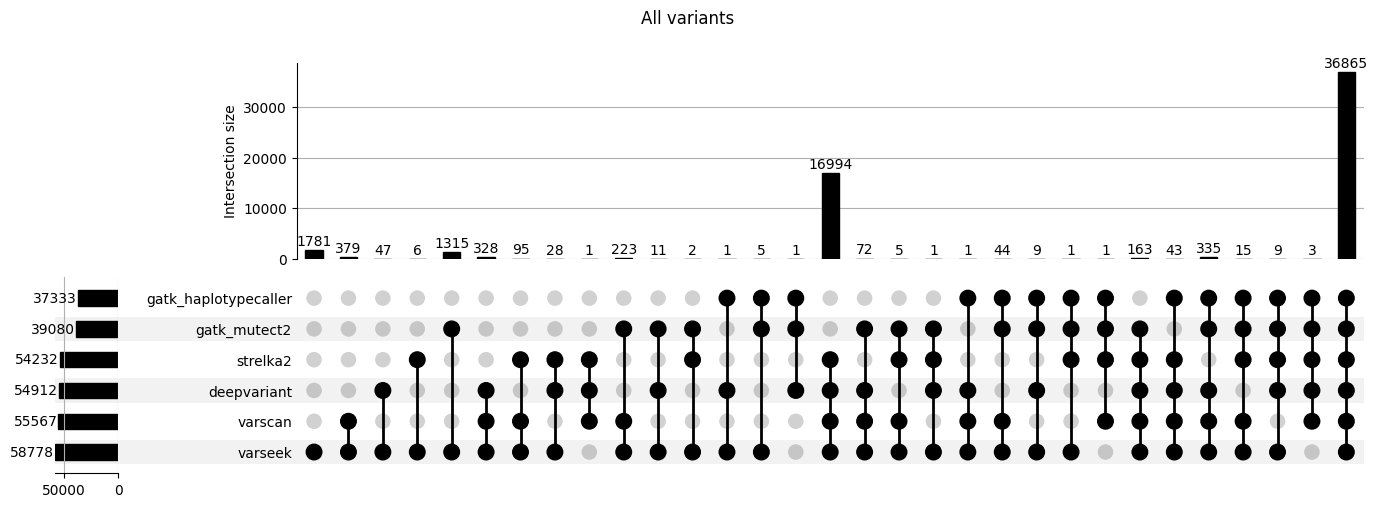

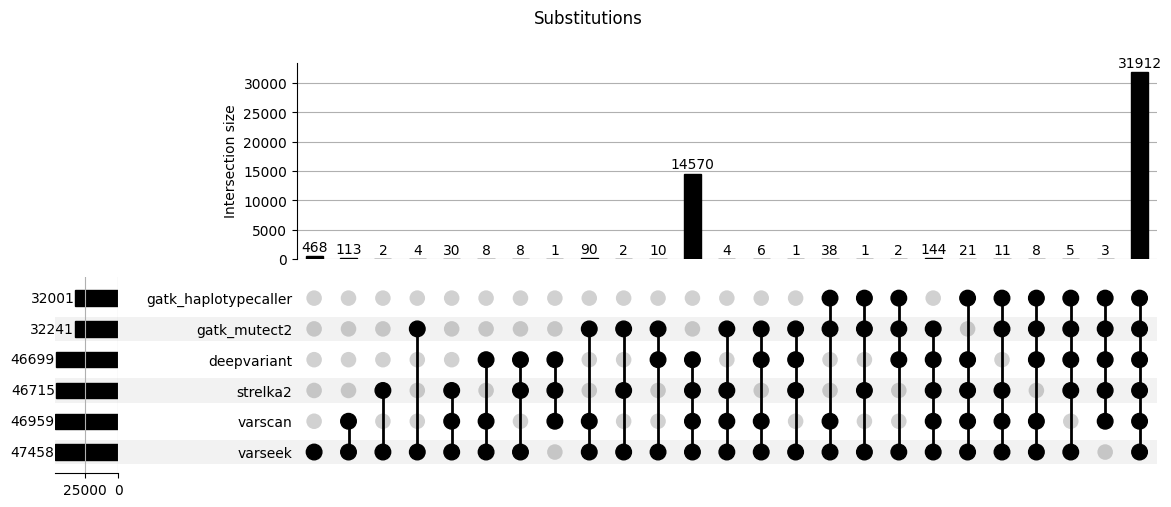

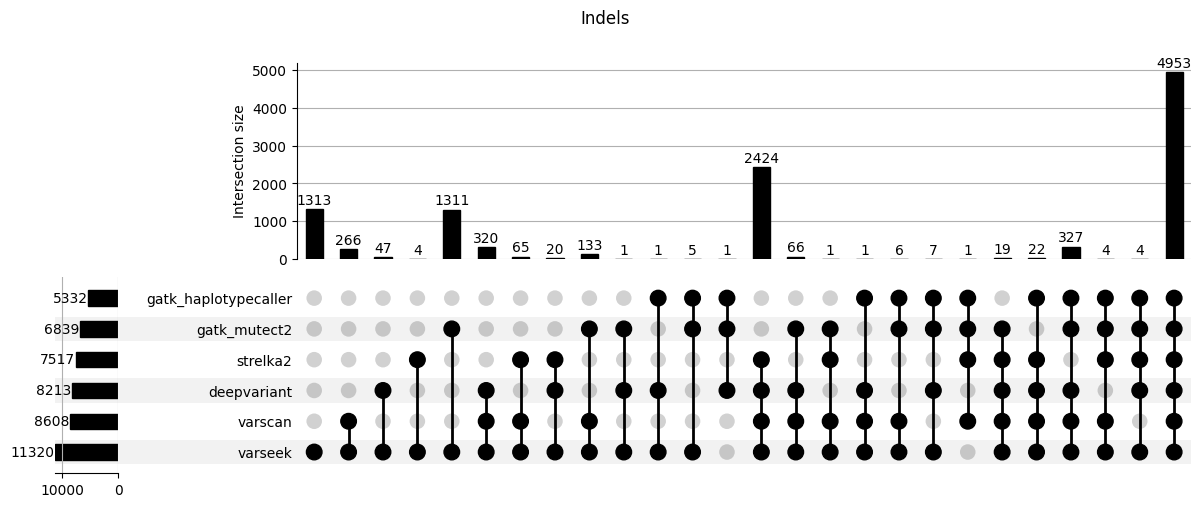

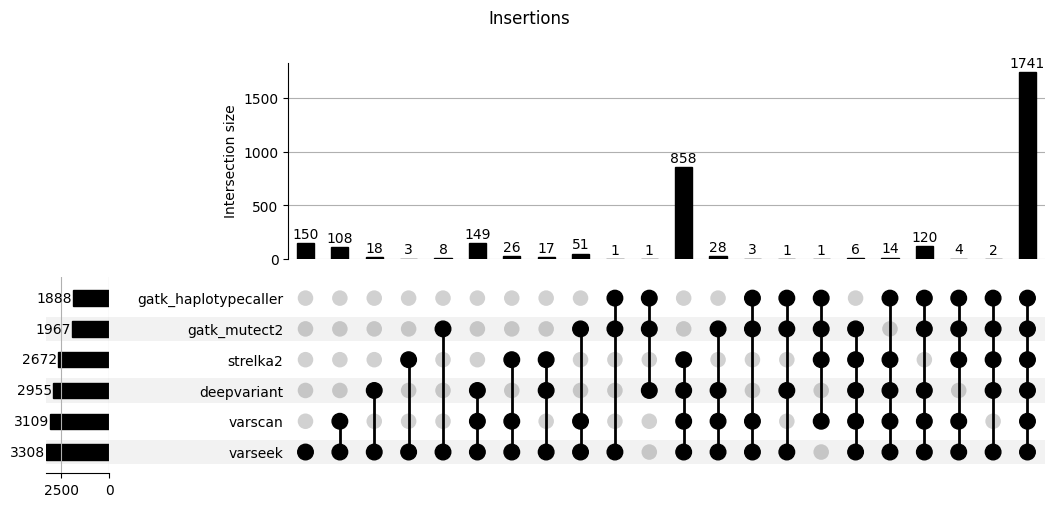

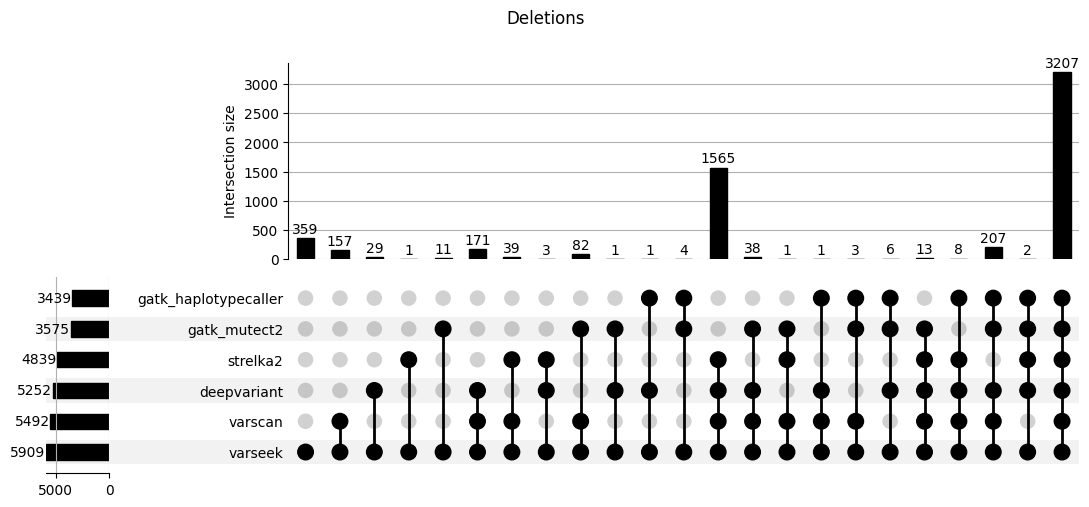

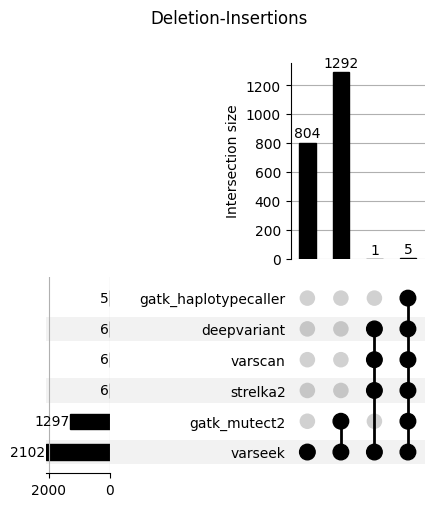

In [11]:
number_of_reads_mutant_min = 128

make_upset(unique_mcrs_df, tools = tools, number_of_reads_mutant_min = number_of_reads_mutant_min, title = "All variants", out_path = f"{fig2_output_dir}/upset_total_depth_min_{number_of_reads_mutant_min}.pdf")
make_upset(substitution_df, tools = tools, number_of_reads_mutant_min = number_of_reads_mutant_min, title = "Substitutions", out_path = f"{fig2_output_dir}/upset_substitution_depth_min_{number_of_reads_mutant_min}.pdf")
make_upset(indel_df, tools = tools, number_of_reads_mutant_min = number_of_reads_mutant_min, title = "Indels", out_path = f"{fig2_output_dir}/upset_indel_depth_min_{number_of_reads_mutant_min}.pdf")
make_upset(insertion_df, tools = tools, number_of_reads_mutant_min = number_of_reads_mutant_min, title = "Insertions", out_path = f"{fig2_output_dir}/upset_insertion_depth_min_{number_of_reads_mutant_min}.pdf")
make_upset(deletion_df, tools = tools, number_of_reads_mutant_min = number_of_reads_mutant_min, title = "Deletions", out_path = f"{fig2_output_dir}/upset_deletion_depth_min_{number_of_reads_mutant_min}.pdf")
make_upset(delins_df, tools = tools, number_of_reads_mutant_min = number_of_reads_mutant_min, title = "Deletion-Insertions", out_path = f"{fig2_output_dir}/upset_delins_depth_min_{number_of_reads_mutant_min}.pdf")

In [12]:
indel_in_synthetic_data_df = indel_df[indel_df["included_in_synthetic_reads_mutant"]].copy()
if number_of_reads_mutant_min:
    indel_in_synthetic_data_df = indel_in_synthetic_data_df.loc[indel_in_synthetic_data_df["number_of_reads_mutant"] >= number_of_reads_mutant_min].copy()

cols_to_sum = [f"mutation_detected_{tool}" for tool in tools]
indel_in_synthetic_data_df["number_of_tools_that_detected_the_variant"] = indel_in_synthetic_data_df[cols_to_sum].sum(axis=1)

indel_in_synthetic_data_detected_by_few_tools_df = indel_in_synthetic_data_df.loc[indel_in_synthetic_data_df["number_of_tools_that_detected_the_variant"] <= 2].copy()
vcrs_headers_in_at_most_2_tools = set(indel_in_synthetic_data_detected_by_few_tools_df["vcrs_header"].tolist())
sorted(list(vcrs_headers_in_at_most_2_tools))[:5]

['ENST00000003100:c.805_806delinsTT',
 'ENST00000005284:c.1934_1935delinsTT',
 'ENST00000005286:c.2129_2130delinsTT',
 'ENST00000005286:c.2730_2731delinsTT',
 'ENST00000007414:c.1548del']

In [ ]:
synthetic_reads_csv_path = "/data/simulated_data_output_BEST_June2025_including_counts_1_and_2/synthetic_reads_updated.parquet"
bam_file_path = "/data/variant_simulation_alternative_tools_BEST_June2025_including_counts_1_and_2/alignment/sample_Aligned.sortedByCoord.out.bam"


synthetic_reads_df = pd.read_parquet(synthetic_reads_csv_path, columns = ["read_id", "vcrs_header"])
synthetic_reads_df_filtered = synthetic_reads_df.loc[synthetic_reads_df["vcrs_header"].isin(vcrs_headers_in_at_most_2_tools)]

sam_file_path = bam_file_path.replace(".bam", ".sam")
output_sam_path = sam_file_path.replace(".sam", "_filtered.sam")

read_ids_in_selected_VCRSs = set(synthetic_reads_df_filtered["read_id"].tolist())
read_id_to_vcrs_header_dict = synthetic_reads_df_filtered.set_index('read_id')['vcrs_header'].to_dict()
vcrs_header_to_sam_count_dict = {vcrs_header: 0 for vcrs_header in vcrs_headers_in_at_most_2_tools}

if not os.path.isfile(sam_file_path):
    !samtools view -h -o {sam_file_path} {bam_file_path}

sam_total_lines = 30_578_771  # fill in here if known
if sam_total_lines is None:
    with open(sam_file_path, 'r') as infile:
        sam_total_lines = sum(1 for _ in infile)

# if not os.path.isfile(output_sam_path):  # commented out because I need to make vcrs_header_to_sam_count_dict regardless of whether the output file exists or not
read_ids_used = set()
with open(sam_file_path, 'r') as infile, open(output_sam_path, 'w') as outfile:
    for line in tqdm(infile, total=sam_total_lines):
        if line.startswith('@'):
            # Always keep SAM header lines
            outfile.write(line)
        else:
            fields = line.strip().split('\t')
            read_id = fields[0]
            if read_id in read_ids_in_selected_VCRSs:
                outfile.write(line)
                vcrs_header = read_id_to_vcrs_header_dict[read_id]
                if not read_id in read_ids_used:  # avoids double-counting multimapped reads
                    vcrs_header_to_sam_count_dict[vcrs_header] += 1
                    read_ids_used.add(read_id)

# vcrs_header_to_sam_count_dict = {'ENST00000001008:c.418C>G': 262,
#  'ENST00000001008:c.702T>C': 4,
#  'ENST00000001008:c.1294dup': 11,
#  'ENST00000001008:c.1353_1354delinsTT': 6,
#  'ENST00000001008:c.1451_1453del': 12}

100%|██████████| 30578771/30578771 [00:52<00:00, 585065.18it/s]


In [20]:
indel_in_synthetic_data_detected_by_few_tools_df['sam_read_count'] = indel_in_synthetic_data_detected_by_few_tools_df['vcrs_header'].map(vcrs_header_to_sam_count_dict)
for col in ["number_of_reads_mutant", "number_of_reads_wt", "sam_read_count"]:
    indel_in_synthetic_data_detected_by_few_tools_df[col] = indel_in_synthetic_data_detected_by_few_tools_df[col].fillna(0).astype(int)

indel_in_synthetic_data_detected_by_few_tools_df['number_of_reads_total'] = indel_in_synthetic_data_detected_by_few_tools_df['number_of_reads_mutant'] + indel_in_synthetic_data_detected_by_few_tools_df['number_of_reads_wt']
indel_in_synthetic_data_detected_by_few_tools_df[['vcrs_header', 'number_of_reads_total', 'number_of_reads_wt', 'number_of_reads_mutant', 'sam_read_count']].head()

vcrs_header  number_of_reads_total  \
267            ENST00000001008:c.559del                    256   
1461          ENST00000002829:c.2652del                    131   
1667     ENST00000003084:c.1492_1494del                    262   
2174          ENST00000003084:c.3905dup                    192   
2555  ENST00000003100:c.805_806delinsTT                    263   

      number_of_reads_wt  number_of_reads_mutant  sam_read_count  
267                    0                     256             256  
1461                   3                     128             131  
1667                   6                     256             262  
2174                  64                     128             192  
2555                   7                     256             263

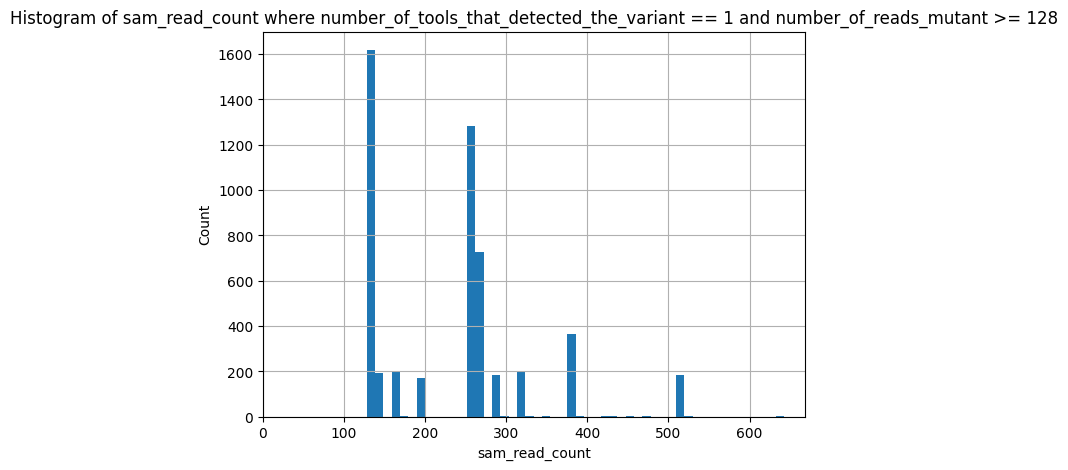

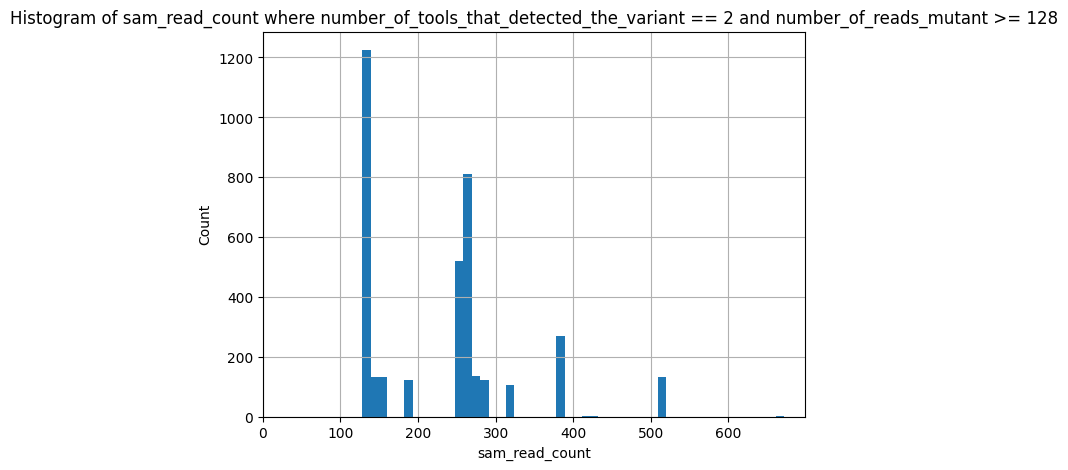

In [21]:
def make_sam_count_histogram(df, title = "sam_read_count histogram"):
    df = df.copy()
    plt.figure(figsize=(7, 5))   # <<< NEW FIGURE EACH TIME

    ax = df["sam_read_count"].hist(
        bins=50
    )

    # ax.set_yscale("log")
    ax.set_xlim(left=0)
    ax.set_xlabel("sam_read_count")
    ax.set_ylabel("Count")
    if title:
        ax.set_title(title)

    plt.show()  # make sure it shows before next plot

make_sam_count_histogram(indel_in_synthetic_data_detected_by_few_tools_df.loc[indel_in_synthetic_data_detected_by_few_tools_df["number_of_tools_that_detected_the_variant"] == 1], title = f"Histogram of sam_read_count where number_of_tools_that_detected_the_variant == 1 and number_of_reads_mutant >= {number_of_reads_mutant_min}")
make_sam_count_histogram(indel_in_synthetic_data_detected_by_few_tools_df.loc[indel_in_synthetic_data_detected_by_few_tools_df["number_of_tools_that_detected_the_variant"] == 2], title = f"Histogram of sam_read_count where number_of_tools_that_detected_the_variant == 2 and number_of_reads_mutant >= {number_of_reads_mutant_min}")

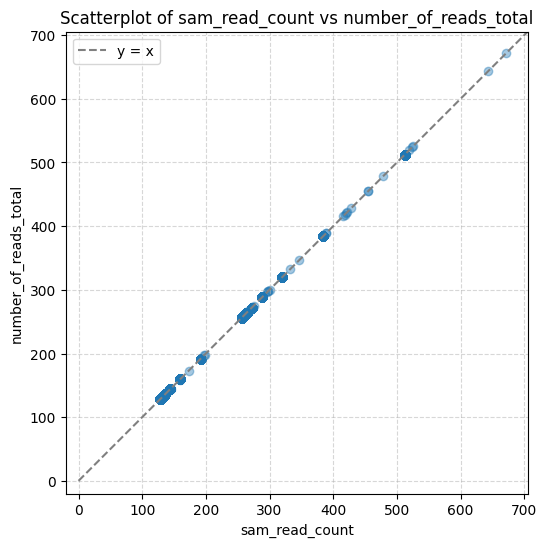

In [22]:
# Determine the maximum value across both columns
max_value = max(
    indel_in_synthetic_data_detected_by_few_tools_df["sam_read_count"].max(),
    indel_in_synthetic_data_detected_by_few_tools_df["number_of_reads_total"].max()
)

# Optionally add a small margin
max_value *= 1.05

plt.figure(figsize=(6,6))

# Scatterplot
plt.scatter(
    indel_in_synthetic_data_detected_by_few_tools_df["sam_read_count"],
    indel_in_synthetic_data_detected_by_few_tools_df["number_of_reads_total"],
    alpha=0.4
)

# y = x line
plt.plot([0, max_value], [0, max_value], color="grey", linestyle="--", label="y = x")

# Axis limits
plt.xlim(-20, max_value)
plt.ylim(-20, max_value)

# Make the aspect ratio square
plt.gca().set_aspect('equal', adjustable='box')

# Labels and title
plt.xlabel("sam_read_count")
plt.ylabel("number_of_reads_total")
plt.title("Scatterplot of sam_read_count vs number_of_reads_total")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)

plt.show()


In [23]:
has_semicolon = pd.Series(synthetic_reads_df_filtered['vcrs_header'].unique()).str.contains(";")
fraction_with_semicolon = has_semicolon.mean()
fraction_with_semicolon

0.012887180646619941

In [24]:
pd.Series(synthetic_reads_df_filtered['vcrs_header'].unique()).head(16)

0     ENST00000252085:c.2930_2932del;ENST00000252087...
1     ENST00000215754:c.728_729delinsGT;ENST00000433...
2     ENST00000252085:c.2915_2917del;ENST00000252087...
3     ENST00000296859:c.4268del;ENST00000514667:c.43...
4     ENST00000331531:c.904del;ENST00000571730:c.135...
5     ENST00000375832:c.530del;ENST00000503322:c.511del
6     ENST00000426342:c.1153_1154delinsTT;ENST000004...
7     ENST00000310137:c.250del;ENST00000412278:c.206del
8     ENST00000380371:c.609del;ENST00000380373:c.635del
9     ENST00000321826:c.1143_1147del;ENST00000393796...
10    ENST00000305139:c.1694_1695delinsGG;ENST000003...
11    ENST00000259053:c.286del;ENST00000504764:c.519...
12     ENST00000299367:c.301del;ENST00000456570:c.80del
13    ENST00000296859:c.388dup;ENST00000514667:c.519dup
14                       ENST00000262577:c.2669_2671del
15                             ENST00000407847:c.503del
dtype: object

In [25]:
# choose one of the entries above (without a semicolon)
chosen_vcrs_header = "ENST00000407847:c.503del"
synthetic_reads_df_filtered.loc[synthetic_reads_df_filtered["vcrs_header"] == chosen_vcrs_header][:5]

read_id               vcrs_header
6029356     vcrs_5331094_5rM_258  ENST00000407847:c.503del
6029357    vcrs_5331094_37fM_259  ENST00000407847:c.503del
6029358    vcrs_5331094_47rM_260  ENST00000407847:c.503del
6029359    vcrs_5331094_27fM_261  ENST00000407847:c.503del
6029360  vcrs_5331094_110fMn_262  ENST00000407847:c.503del

In [26]:
# choose one of the read IDs above
chosen_read_id = 'vcrs_5331094_5rM_258'
!grep {chosen_read_id} {output_sam_path}

vcrs_5331094_5rM_258	16	5	122425798	60	8S142M	*	0	0	TCCCTCACGAGGCGCAGGCCCGCTCAAGGGCAGCGGCGCCGCGGGTCTCCTGAGCGCGCCGCAGCCTCTTCAGCCGCCGCCGCCGCCCCCGCCCCCGGAGCGCGCTGAGCCTCCGCCGGACAGCCTGCGCCCGCGGCCCGCCTCTCTCTC	IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII	NH:i:1	HI:i:1	AS:i:140	nM:i:0


In [27]:
# does anything remotely close to this position occur in my output VCFs?
alt_tool_vcf = "/home/jmrich/Desktop/RLSRWP_2025/data/variant_simulation_alternative_tools_BEST_June2025_including_counts_1_and_2/vcfs/haplotypecaller/haplotypecaller_output_unfiltered.g.vcf.gz"
position = "122425798"

position = position[:-4]  # chop off last 4 characters to have it be within roughly ± 10_000 bp of the position in the VCF
!zgrep {position} {alt_tool_vcf}

1	212242032	.	G	A	89.64	.	AC=1;AF=0.500;AN=2;BaseQRankSum=-9.757;DP=103;ExcessHet=0.0000;FS=1.053;MLEAC=1;MLEAF=0.500;MQ=60.00;MQRankSum=0.000;QD=0.88;ReadPosRankSum=-0.819;SOR=0.456	GT:AD:DP:GQ:PL	0/1:86,16:102:97:97,0,2426
14	51224285	.	G	A	1371.64	.	AC=1;AF=0.500;AN=2;BaseQRankSum=-9.033;DP=108;ExcessHet=0.0000;FS=1.583;MLEAC=1;MLEAF=0.500;MQ=60.00;MQRankSum=0.000;QD=13.06;ReadPosRankSum=2.591;SOR=0.648	GT:AD:DP:GQ:PL	0/1:45,60:105:99:1379,0,1142
15	81224244	.	A	G	1159.64	.	AC=1;AF=0.500;AN=2;BaseQRankSum=8.516;DP=105;ExcessHet=0.0000;FS=4.820;MLEAC=1;MLEAF=0.500;MQ=60.00;MQRankSum=0.000;QD=11.04;ReadPosRankSum=0.730;SOR=0.707	GT:AD:DP:GQ:PL	0/1:59,46:105:99:1167,0,1307
16	84256020	.	G	A	1687.64	.	AC=1;AF=0.500;AN=2;BaseQRankSum=-22.526;DP=576;ExcessHet=0.0000;FS=5.151;MLEAC=1;MLEAF=0.500;MQ=60.00;MQRankSum=0.000;QD=2.99;ReadPosRankSum=0.816;SOR=0.887	GT:AD:DP:GQ:PL	0/1:436,128:564:99:1695,0,12242
19	41712242	.	C	T	27.64	.	AC=1;AF=0.500;AN=2;BaseQRankSum=-4.598;DP=54;ExcessHet=0.000

In [28]:
# does anything remotely close to this position occur in my output VCFs?
alt_tool_vcf = "/home/jmrich/Desktop/RLSRWP_2025/data/variant_simulation_alternative_tools_BEST_June2025_including_counts_1_and_2/results/variants/variants.vcf.gz"
position = "122425798"

position = position[:-4]  # chop off last 4 characters to have it be within roughly ± 10_000 bp of the position in the VCF
!zgrep {position} {alt_tool_vcf}

1	163122424	.	G	C	0	LowGQX;NoPassedVariantGTs	SNVHPOL=4;MQ=60	GT:GQ:GQX:DP:DPF:AD:ADF:ADR:SB:FT:PL	0/1:7:0:51:0:50,1:24,0:26,1:0.0:LowGQX:8,0,370
1	212242023	.	G	A	20	PASS	SNVHPOL=2;MQ=60	GT:GQ:GQX:DP:DPF:AD:ADF:ADR:SB:FT:PL	0/1:52:9:100:0:93,7:42,1:51,6:-24.7:PASS:54,0,370
1	212242032	.	G	A	75	PASS	SNVHPOL=3;MQ=60	GT:GQ:GQX:DP:DPF:AD:ADF:ADR:SB:FT:PL	0/1:108:14:103:0:87,16:37,8:50,8:-23.3:PASS:109,0,370
10	46122428	.	A	T	0	LowGQX;NoPassedVariantGTs	SNVHPOL=3;MQ=60	GT:GQ:GQX:DP:DPF:AD:ADF:ADR:SB:FT:PL	0/1:3:0:75:0:74,1:34,1:40,0:0.0:LowGQX:3,0,370
10	127512242	.	A	G	0	LowGQX;NoPassedVariantGTs	SNVHPOL=2;MQ=60	GT:GQ:GQX:DP:DPF:AD:ADF:ADR:SB:FT:PL	0/1:6:0:57:0:56,1:30,0:26,1:0.0:LowGQX:7,0,370
11	28112242	.	C	G	0	LowGQX;NoPassedVariantGTs	SNVHPOL=3;MQ=60	GT:GQ:GQX:DP:DPF:AD:ADF:ADR:SB:FT:PL	0/1:5:0:63:0:62,1:36,1:26,0:0.0:LowGQX:5,0,370
14	50122426	.	C	A	0	LowGQX;NoPassedVariantGTs	SNVHPOL=2;MQ=57	GT:GQ:GQX:DP:DPF:AD:ADF:ADR:SB:FT:PL	0/1:16:0:22:0:21,1:9,1:12,0:0.0:LowGQX:17,0,345
14	501

In [29]:
# find the VCRS VCF ID for the chosen VCRS id
chosen_vcrs_vcf_id = indel_in_synthetic_data_detected_by_few_tools_df.loc[indel_in_synthetic_data_detected_by_few_tools_df["vcrs_header"] == chosen_vcrs_header, "VCF_ID"].values[0]
chosen_vcrs_vcf_id

'variant_4337984'

In [30]:
# search for this VCRS VCF ID in the COSMIC ground truth VCF
cosmic_vcf = "/home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output_BEST_June2025_including_counts_1_and_2/synthetic_cosmic_simulated_reads.vcf.gz"
!zgrep {chosen_vcrs_vcf_id} {cosmic_vcf}

5	122425797	variant_4337984	GG	G	.	PASS	.	GT	0/1


In [31]:
import pyfastx

cdna_fa_path = "/home/jmrich/Desktop/RLSRWP_2025/data/reference/ensembl_grch37_release93/Homo_sapiens.GRCh37.cdna.all.fa"

cdna_fa = pyfastx.Fasta(cdna_fa_path, build_index=True)

In [35]:
cdna_fa['ENST00000407847.4'].seq[499:510]

'ACGGAGGCGCA'

In [ ]:
reference_fasta = "/home/jmrich/Desktop/RLSRWP_2025/data/reference/ensembl_grch37_release93/Homo_sapiens.GRCh37.dna.primary_assembly.fa"
ground_truth_vcf = "/home/jmrich/Desktop/RLSRWP_2025/vcf_cosmic_test.vcf"
test_vcf = "/home/jmrich/Desktop/RLSRWP_2025/vcf_haplotypecaller_test.vcf"

!bcftools view -h /home/jmrich/Desktop/RLSRWP_2025/data/variant_simulation_alternative_tools_BEST_June2025_including_counts_1_and_2/vcfs/haplotypecaller/haplotypecaller_output_unfiltered.g.vcf.gz > {test_vcf}
!bcftools view -h /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output_BEST_June2025_including_counts_1_and_2/synthetic_cosmic_simulated_reads.vcf.gz > {ground_truth_vcf}

haplotypecaller_fields = [
    "5",
    "122425796",
    ".",
    "CG",
    "C",
    "6353.03",
    ".",
    "AC=2;AF=1.00;AN=2;BaseQRankSum=-0.767;DP=218;ExcessHet=0.0000;FS=1.186;MLEAC=2;MLEAF=1.00;MQ=59.45;MQRankSum=0.000;QD=33.09;ReadPosRankSum=0.349;SOR=0.517",
    "GT:AD:DP:GQ:PL",
    "1/1:11,181:192:99:6367,168,0"
]

# Join them with tabs
line = "\t".join(haplotypecaller_fields)
with open(test_vcf, "a") as f:
    f.write(line + "\n")



cosmic_fields = [
    "5",
    "122425797",
    "variant_4337984",
    "GG",
    "G",
    ".",
    "PASS",
    ".",
    "GT",
    "0/1"
]

# Join them with tabs
line = "\t".join(cosmic_fields)
with open(ground_truth_vcf, "a") as f:
    f.write(line + "\n")


In [44]:
output_dir = "/home/jmrich/Desktop/RLSRWP_2025/happy_test3"
output_prefix = "happy"
    
ground_truth_vcf_dir = os.path.dirname(ground_truth_vcf)
test_vcf_dir = os.path.dirname(test_vcf)
reference_fasta_dir = os.path.dirname(reference_fasta)
output_prefix_full = os.path.join(output_dir, output_prefix)

command = f"docker run --rm -v {ground_truth_vcf_dir}:{ground_truth_vcf_dir} -v {test_vcf_dir}:{test_vcf_dir} -v {reference_fasta_dir}:{reference_fasta_dir} -v {output_dir}:{output_dir} mgibio/hap.py:v0.3.12 /opt/hap.py/bin/hap.py -r {reference_fasta} --engine=xcmp -o {output_prefix_full} {ground_truth_vcf} {test_vcf}"
# command = f"docker run --rm -v {ground_truth_vcf_dir}:{ground_truth_vcf_dir} -v {test_vcf_dir}:{test_vcf_dir} -v {reference_fasta_dir}:{reference_fasta_dir} -v {output_dir}:{output_dir} mgibio/hap.py:v0.3.12 /opt/hap.py/bin/hap.py -r {reference_fasta} --engine=scmp-somatic -o {output_prefix_full} {ground_truth_vcf} {test_vcf}"
subprocess.run(command, shell = True)

2025-07-03 17:25:32,273 WARNING  No reference file found at default locations. You can set the environment variable 'HGREF' or 'HG19' to point to a suitable Fasta file.
[I] Total VCF records:         1
[I] Non-reference VCF records: 1
[I] Total VCF records:         1
[I] Non-reference VCF records: 1


Hap.py v0.3.12
Benchmarking Summary:
Type Filter  TRUTH.TOTAL  TRUTH.TP  TRUTH.FN  QUERY.TOTAL  QUERY.FP  QUERY.UNK  FP.gt  FP.al  METRIC.Recall  METRIC.Precision  METRIC.Frac_NA  METRIC.F1_Score  TRUTH.TOTAL.TiTv_ratio  QUERY.TOTAL.TiTv_ratio  TRUTH.TOTAL.het_hom_ratio  QUERY.TOTAL.het_hom_ratio
INDEL    ALL            1         0         1            1         1          0      0      1            0.0               0.0             0.0              NaN                     NaN                     NaN                        NaN                        0.0
INDEL   PASS            1         0         1            1         1          0      0      1            0.0               0.0             0.0              NaN                     NaN                     NaN                        NaN                        0.0


CompletedProcess(args='docker run --rm -v /home/jmrich/Desktop/RLSRWP_2025:/home/jmrich/Desktop/RLSRWP_2025 -v /home/jmrich/Desktop/RLSRWP_2025:/home/jmrich/Desktop/RLSRWP_2025 -v /home/jmrich/Desktop/RLSRWP_2025/data/reference/ensembl_grch37_release93:/home/jmrich/Desktop/RLSRWP_2025/data/reference/ensembl_grch37_release93 -v /home/jmrich/Desktop/RLSRWP_2025/happy_test3:/home/jmrich/Desktop/RLSRWP_2025/happy_test3 mgibio/hap.py:v0.3.12 /opt/hap.py/bin/hap.py -r /home/jmrich/Desktop/RLSRWP_2025/data/reference/ensembl_grch37_release93/Homo_sapiens.GRCh37.dna.primary_assembly.fa --engine=xcmp -o /home/jmrich/Desktop/RLSRWP_2025/happy_test3/happy /home/jmrich/Desktop/RLSRWP_2025/vcf_cosmic_test.vcf /home/jmrich/Desktop/RLSRWP_2025/vcf_haplotypecaller_test.vcf', returncode=0)

In [45]:
output_dir = "/home/jmrich/Desktop/RLSRWP_2025/happy_test4"
output_prefix = "happy"
    
ground_truth_vcf_dir = os.path.dirname(ground_truth_vcf)
test_vcf_dir = os.path.dirname(test_vcf)
reference_fasta_dir = os.path.dirname(reference_fasta)
output_prefix_full = os.path.join(output_dir, output_prefix)

command = f"docker run --rm -v {ground_truth_vcf_dir}:{ground_truth_vcf_dir} -v {test_vcf_dir}:{test_vcf_dir} -v {reference_fasta_dir}:{reference_fasta_dir} -v {output_dir}:{output_dir} mgibio/hap.py:v0.3.12 /opt/hap.py/bin/hap.py -r {reference_fasta} --engine=scmp-distance -o {output_prefix_full} {ground_truth_vcf} {test_vcf}"
# command = f"docker run --rm -v {ground_truth_vcf_dir}:{ground_truth_vcf_dir} -v {test_vcf_dir}:{test_vcf_dir} -v {reference_fasta_dir}:{reference_fasta_dir} -v {output_dir}:{output_dir} mgibio/hap.py:v0.3.12 /opt/hap.py/bin/hap.py -r {reference_fasta} --engine=scmp-somatic -o {output_prefix_full} {ground_truth_vcf} {test_vcf}"
subprocess.run(command, shell = True)

2025-07-03 17:25:49,245 WARNING  No reference file found at default locations. You can set the environment variable 'HGREF' or 'HG19' to point to a suitable Fasta file.
[I] Total VCF records:         1
[I] Non-reference VCF records: 1
[I] Total VCF records:         1
[I] Non-reference VCF records: 1


Hap.py v0.3.12


2025-07-03 17:25:52,291 ERROR    Exception when running scmp: Command line bcftools merge --force-samples /tmp/truth.ppqB7NOb.vcf.gz /tmp/query.ppELHydL.vcf.gz -o /tmp/tmpMhnisO got return code 255.
STDOUT: 
STDERR: Incorrect number of AD fields (2) at 5:122425796, cannot merge.

2025-07-03 17:25:52,291 ERROR    ------------------------------------------------------------
2025-07-03 17:25:52,292 ERROR    Traceback (most recent call last):
2025-07-03 17:25:52,292 ERROR      File "/opt/hap.py/lib/python27/Haplo/scmp.py", line 46, in runSCmp
2025-07-03 17:25:52,293 ERROR        runBcftools(*vargs)
2025-07-03 17:25:52,293 ERROR      File "/opt/hap.py/lib/python27/Tools/bcftools.py", line 64, in runBcftools
2025-07-03 17:25:52,294 ERROR        return runShellCommand('bcftools', *args)
2025-07-03 17:25:52,294 ERROR      File "/opt/hap.py/lib/python27/Tools/bcftools.py", line 52, in runShellCommand
2025-07-03 17:25:52,294 ERROR        raise Exception("Command line {} got return code {}.\nSTDO

CompletedProcess(args='docker run --rm -v /home/jmrich/Desktop/RLSRWP_2025:/home/jmrich/Desktop/RLSRWP_2025 -v /home/jmrich/Desktop/RLSRWP_2025:/home/jmrich/Desktop/RLSRWP_2025 -v /home/jmrich/Desktop/RLSRWP_2025/data/reference/ensembl_grch37_release93:/home/jmrich/Desktop/RLSRWP_2025/data/reference/ensembl_grch37_release93 -v /home/jmrich/Desktop/RLSRWP_2025/happy_test4:/home/jmrich/Desktop/RLSRWP_2025/happy_test4 mgibio/hap.py:v0.3.12 /opt/hap.py/bin/hap.py -r /home/jmrich/Desktop/RLSRWP_2025/data/reference/ensembl_grch37_release93/Homo_sapiens.GRCh37.dna.primary_assembly.fa --engine=scmp-distance -o /home/jmrich/Desktop/RLSRWP_2025/happy_test4/happy /home/jmrich/Desktop/RLSRWP_2025/vcf_cosmic_test.vcf /home/jmrich/Desktop/RLSRWP_2025/vcf_haplotypecaller_test.vcf', returncode=1)

## varseek ref

In [3]:
fig3_output_dir = os.path.join(varseek_directory, "data", "Fig3")
stats_file_vk_ref = os.path.join(fig3_output_dir, "time_and_memory_benchmarking_report_vk_ref.txt")
stats_file_vk_count = os.path.join(fig3_output_dir, "time_and_memory_benchmarking_report_vk_count.txt")

In [4]:
index_ref_time_and_memory_benchmarking_stat_url = "https://caltech.box.com/shared/static/lfnvbvknsggd8k3jj71emured1g90xq8.txt"
index_count_time_and_memory_benchmarking_stat_url = "https://caltech.box.com/shared/static/z13p9lh1ewtw7uglkac8sbka3shpe7pm.txt"

if not os.path.isfile(stats_file_vk_ref):
    subprocess.run(["wget", index_ref_time_and_memory_benchmarking_stat_url, "-O", stats_file_vk_ref])

if not os.path.isfile(stats_file_vk_count):
    subprocess.run(["wget", index_count_time_and_memory_benchmarking_stat_url, "-O", stats_file_vk_count])

In [5]:
# Regex patterns
runtime_pattern_ref = re.compile(r"([\w\s]+)\s(\d+)\svariants\s\d+\sthreads\sRuntime:\s(\d+(?:\.\d+)?)\sminutes,\s([\d.]+)\sseconds")
memory_pattern_ref = re.compile(r"([\w\s]+)\s(\d+)\svariants\s\d+\sthreads\sPeak memory usage:\s([\d.]+)\s(GB|MB)")
runtime_pattern_count = re.compile(r"([\w\s]+)\s(\d+)\svariants\s\d+\sreads\s\d+\sthreads\sRuntime:\s(\d+(?:\.\d+)?)\sminutes,\s([\d.]+)\sseconds")
memory_pattern_count = re.compile(r"([\w\s]+)\s(\d+)\svariants\s\d+\sreads\s\d+\sthreads\sPeak memory usage:\s([\d.]+)\s(GB|MB)")

data = []

# Read file and extract information
with open(stats_file_vk_ref, "r") as f:
    for line in f:
        # Extract runtime
        runtime_match = runtime_pattern_ref.match(line)
        if runtime_match:
            tool, variants, minutes, seconds = runtime_match.groups()
            runtime = round((int(float(minutes)) * 60 + float(seconds)) / 60, 2)  # units: minutes
            data.append({"Tool": tool, "Variants": int(variants), "Metric": "Runtime", "Value": runtime, "Extrapolated": False})

        # Extract memory usage
        memory_match = memory_pattern_ref.match(line)
        if memory_match:
            tool, variants, mem_value, unit = memory_match.groups()
            memory = round(float(mem_value) if unit == "GB" else float(mem_value) / 1024, 2)  # units: GB
            data.append({"Tool": tool, "Variants": int(variants), "Metric": "Memory", "Value": memory, "Extrapolated": False})

# Convert to DataFrame
time_and_memory_df_index_ref = pd.DataFrame(data)


data = []

# Read file and extract information
with open(stats_file_vk_count, "r") as f:
    for line in f:
        # Extract runtime
        runtime_match = runtime_pattern_count.match(line)
        if runtime_match:
            tool, variants, minutes, seconds = runtime_match.groups()
            runtime = round((int(float(minutes)) * 60 + float(seconds)) / 60, 2)  # units: minutes
            data.append({"Tool": tool, "Variants": int(variants), "Metric": "Runtime", "Value": runtime, "Extrapolated": False})

        # Extract memory usage
        memory_match = memory_pattern_count.match(line)
        if memory_match:
            tool, variants, mem_value, unit = memory_match.groups()
            memory = round(float(mem_value) if unit == "GB" else float(mem_value) / 1024, 2)  # units: GB
            data.append({"Tool": tool, "Variants": int(variants), "Metric": "Memory", "Value": memory, "Extrapolated": False})

# Convert to DataFrame
time_and_memory_df_index_count = pd.DataFrame(data)

print("Units: minutes for runtime, GB for memory")
print(time_and_memory_df_index_ref.head())
print(time_and_memory_df_index_count.head())

Units: minutes for runtime, GB for memory
     Tool  Variants   Metric  Value  Extrapolated
0  vk ref      1000  Runtime   3.29         False
1  vk ref      1000   Memory  14.46         False
2  vk ref      4000  Runtime   6.98         False
3  vk ref      4000   Memory  14.45         False
4  vk ref     16000  Runtime   4.02         False
       Tool  Variants   Metric  Value  Extrapolated
0  vk count      1000  Runtime  18.09         False
1  vk count      1000   Memory   2.00         False
2  vk count      4000  Runtime  18.04         False
3  vk count      4000   Memory   2.00         False
4  vk count     16000  Runtime  17.93         False


### Note this is at 16 threads, 256,000,000 reads

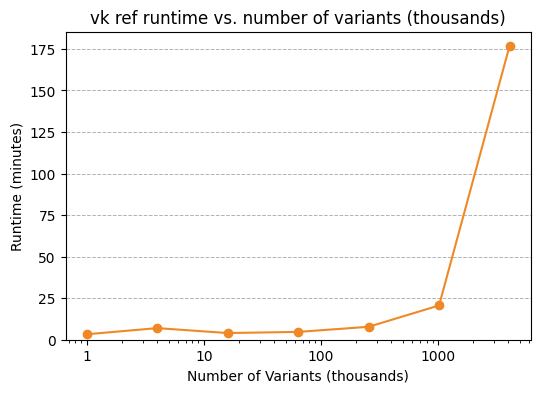

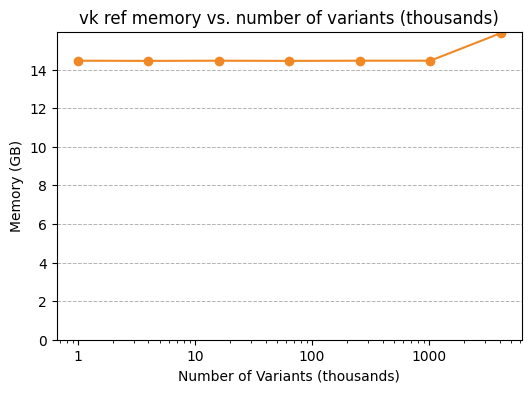

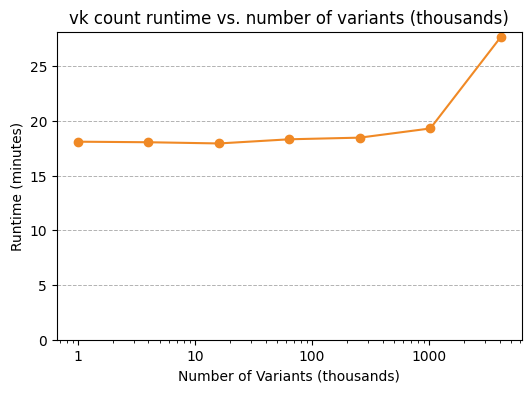

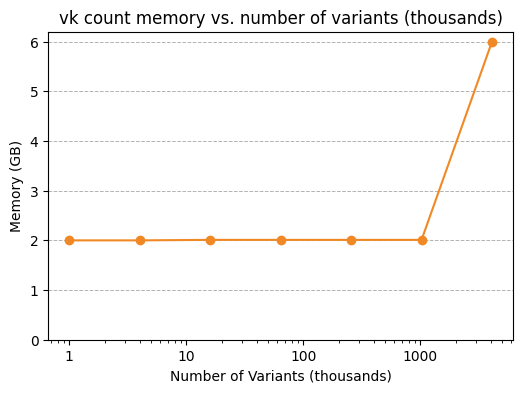

In [ ]:
from RLSRWP_2025.visualization_utils import plot_time_and_memory_benchmarking

plot_time_and_memory_benchmarking(time_and_memory_df_index_ref, metric_name = "Runtime", units="minutes", log_x=True, title="vk ref runtime vs. number of variants (thousands)", x_col="Variants", x_col_units="thousands", y_col="Value", y_min=0, output_file = f"{fig3_output_dir}/runtime_benchmarking_index_vk_ref.pdf")
plot_time_and_memory_benchmarking(time_and_memory_df_index_ref, metric_name = "Memory", units="GB", log_x=True, title="vk ref memory vs. number of variants (thousands)", x_col="Variants", x_col_units="thousands", y_col="Value", y_min=0, output_file = f"{fig3_output_dir}/memory_benchmarking_index_vk_ref.pdf")
plot_time_and_memory_benchmarking(time_and_memory_df_index_count, metric_name = "Runtime", units="minutes", log_x=True, title="vk count runtime vs. number of variants (thousands)", x_col="Variants", x_col_units="thousands", y_col="Value", y_min=0, output_file = f"{fig3_output_dir}/runtime_benchmarking_index_vk_count.pdf")
plot_time_and_memory_benchmarking(time_and_memory_df_index_count, metric_name = "Memory", units="GB", log_x=True, title="vk count memory vs. number of variants (thousands)", x_col="Variants", x_col_units="thousands", y_col="Value", y_min=0, output_file = f"{fig3_output_dir}/memory_benchmarking_index_vk_count.pdf")